<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

2.0.0+cu118
Running on cpu


In [ ]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess Iris Dataset

In [ ]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dst.data)

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = scaled_data[train_indices]; train_target = dst.target[train_indices]
test_data = scaled_data[test_indices]; test_target = dst.target[test_indices]

# require inputs/outputs to be 2D for uniformity
train_target = np.expand_dims(train_target, axis=1)
test_target = np.expand_dims(test_target, axis=1)

# reference variables for code
input_dim = 4
output_dim = 3

# Setting up Fully Connected Neural Network

In [ ]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [ ]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Train Model Normally

score: 27/30


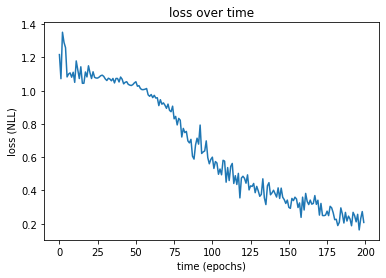

In [ ]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 200
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG

In [ ]:
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

[117, 143, 7, 44, 149, 72, 51, 146, 49, 122, 107, 139, 119, 80, 111, 54]


  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 3.8000, 6.7000, 2.2000], dtype=torch.float64) tensor([7.4751, 3.3349, 6.2798, 2.1893], grad_fn=<SelectBackward0>) RE (AE / TN):  0.0599453508498275
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([6.8891, 3.6305, 5.9689, 2.0675], grad_fn=<SelectBackward0>) RE (AE / TN):  0.05109023313695406
tensor([5.0000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([6.0163, 1.5577, 4.3542, 3.5206], grad_fn=<SelectBackward0>) RE (AE / TN):  0.7793969330616535
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([8.0286, 3.4432, 1.9641, 7.9948], grad_fn=<SelectBackward0>) RE (AE / TN):  1.2252878473986821
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([6.3888, 3.2922, 5.6639, 1.7632], grad_fn=<SelectBackward0>) RE (AE / TN):  0.09386511277501497
tensor([6.3000, 2.5000, 4.9000, 1.5000], dtype=torch.float64) tensor([6.8149, 2.7578, 5.6682, 1.5642], grad_fn=<SelectBackward0>) 

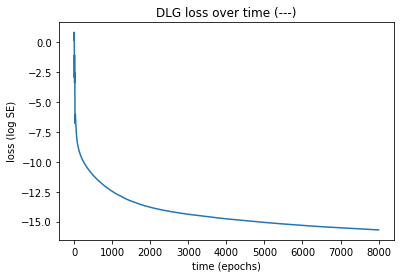

In [ ]:
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [ ]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 500
batch_size = 16
dlg_rate = 5
verbose = True
losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                         gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=500, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = False)
test_net(net, test_data, test_target)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([ 7.9428,  7.1248, 19.8789,  4.4254]) RE (AE / TN):  1.2754409573546341
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([8.0208, 2.3024, 5.7272, 3.2845]) RE (AE / TN):  0.3089501735628772
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([ 7.6523,  5.5300, 14.2522,  3.5632]) RE (AE / TN):  0.8958541627895794
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([6.5393, 2.3618, 4.1108, 1.5705]) RE (AE / TN):  0.11407708785245477
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.0472,  3.6594, -0.3735, -0.8541]) RE (AE / TN):  0.3970629369691647
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([5.6489, 2.7416, 3.1202, 1.3940]) RE (AE / TN):  0.11149398758081898
tensor([6.1000, 3.0000, 4.6000, 1.4000], dtype=torch.float64) tensor([5.4001, 2.6558, 5.2890, 0.7307]) RE (AE / TN):

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([-14.3105,   4.7840, 105.0541, -23.5359]) RE (AE / TN):  11.746293254099443
tensor([6.0000, 2.2000, 4.0000, 1.0000], dtype=torch.float64) tensor([6.4469, 2.3762, 5.4078, 2.1288]) RE (AE / TN):  0.2455244556890942
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.3230,  3.2700, -0.5697,  0.1925]) RE (AE / TN):  0.3643768577776725
tensor([4.8000, 3.0000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 5.3834,  3.0942, -0.1408, -0.3422]) RE (AE / TN):  0.2929551517777163
tensor([4.6000, 3.2000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 4.6934,  3.6197, -0.0454, -0.0517]) RE (AE / TN):  0.26453379908282465
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.5013, 2.2200, 5.3670, 2.1368]) RE (AE / TN):  0.13776570269675378
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 4.8329,  3.6963,  0.0784, -0.1442]) R

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.1000, 5.6000, 2.4000], dtype=torch.float64) tensor([7.1200, 2.7912, 5.9581, 2.5638]) RE (AE / TN):  0.06825727111513229
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([7.6095, 2.9090, 6.2498, 2.0800]) RE (AE / TN):  0.03384230762947252
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 4.5249,  2.5754,  1.9390, -0.0212]) RE (AE / TN):  0.14517482699108758
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([ 0.2446,  3.6945, -5.3415, -2.8381]) RE (AE / TN):  1.5418332837805053
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([5.6602, 2.5069, 6.0037, 1.9835]) RE (AE / TN):  0.20884371511882618
tensor([6.0000, 2.2000, 4.0000, 1.0000], dtype=torch.float64) tensor([ 0.2950,  3.7988, -5.9061, -2.7021]) RE (AE / TN):  1.5938816493490011
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 0.4887,  3.6686, -5.2832, -1.9848]) RE (AE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([6.1742, 2.8045, 5.7229, 2.3501]) RE (AE / TN):  0.08510613918397815
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([6.3068, 2.4938, 5.5360, 2.3669]) RE (AE / TN):  0.0810869100055372
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([6.9152, 2.9015, 6.0038, 1.7993]) RE (AE / TN):  0.07172298885268799
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([6.7156, 2.4722, 5.0637, 1.1546]) RE (AE / TN):  0.08150797367381707
tensor([6.1000, 2.6000, 5.6000, 1.4000], dtype=torch.float64) tensor([5.7336, 3.4806, 5.7686, 1.7835]) RE (AE / TN):  0.11849454892743924
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([6.2076, 3.5488, 4.9111, 2.5772]) RE (AE / TN):  0.0779318479809722
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([5.1627, 2.6799, 3.6703, 0.7406]) RE (AE / TN):  0.086626

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([7.4613, 3.3713, 5.6031, 1.6492]) RE (AE / TN):  0.08350550379861811
tensor([4.6000, 3.2000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 4.6025,  2.9601,  0.8386, -0.0379]) RE (AE / TN):  0.1133704719397515
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([4.8655, 2.4799, 5.3763, 1.9159]) RE (AE / TN):  0.35111708092405947
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([7.0329, 4.8428, 4.3265, 2.0115]) RE (AE / TN):  0.21812409796126694
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([5.0403, 3.4931, 0.4286, 0.1025]) RE (AE / TN):  0.19195892678613988
tensor([5.8000, 4.0000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 5.5750,  3.3117,  0.0905, -0.1226]) RE (AE / TN):  0.19072048968608912
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([6.4230, 3.8946, 6.2548, 2.5685]) RE (AE / TN): 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([9.4778, 2.6590, 9.4004, 3.9711]) RE (AE / TN):  0.3517811826974714
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([ 4.1872,  3.4503, -1.3840, -0.9442]) RE (AE / TN):  0.4520613142421044
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([8.0765, 2.8126, 6.0403, 2.4936]) RE (AE / TN):  0.42919892789407205
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([5.9043, 2.3413, 2.5656, 0.8214]) RE (AE / TN):  0.26499766109731543
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([8.8798, 3.0859, 8.5387, 3.3396]) RE (AE / TN):  0.35805714345341605
tensor([6.3000, 2.9000, 5.6000, 1.8000], dtype=torch.float64) tensor([6.9819, 3.0202, 8.3345, 2.3879]) RE (AE / TN):  0.31685509540082507
tensor([5.5000, 2.3000, 4.0000, 1.3000], dtype=torch.float64) tensor([5.1157, 2.3839, 3.6955, 0.9559]) RE (AE / TN):  0.08

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([6.9148, 2.7661, 7.3376, 2.1491]) RE (AE / TN):  0.19581389880289496
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([5.3094, 4.6081, 0.2370, 1.0388]) RE (AE / TN):  0.2575295799637665
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.7951, 5.3025, 2.0601, 3.8079]) RE (AE / TN):  0.5235246757432109
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([7.9469, 3.7582, 3.0982, 2.8130]) RE (AE / TN):  0.394769358723484
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.6505,  3.1952, -0.1944, -0.5960]) RE (AE / TN):  0.3261274210451178
tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64) tensor([7.1098, 3.4662, 6.6962, 2.3864]) RE (AE / TN):  0.10796274944313188
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 7.6730,  6.0554, -0.1784,  3.2778]) RE (AE / TN):  0.7

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([9.1070, 3.1061, 8.3938, 2.7567]) RE (AE / TN):  0.5525372631982561
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([8.0045, 1.9272, 7.7233, 3.9463]) RE (AE / TN):  0.6670100886098682
tensor([6.0000, 2.2000, 4.0000, 1.0000], dtype=torch.float64) tensor([9.2456, 1.8194, 7.5079, 2.5775]) RE (AE / TN):  0.6636315922775335
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([ 9.6060,  1.8565, 11.9071,  4.9838]) RE (AE / TN):  0.7405598227664486
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([8.6051, 1.9125, 7.4532, 3.3153]) RE (AE / TN):  1.1171227007458335
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([ 6.7468,  1.8108, 12.5977,  4.6546]) RE (AE / TN):  0.8123419057908168
tensor([7.7000, 3.8000, 6.7000, 2.2000], dtype=torch.float64) tensor([10.0884,  2.0811, 11.3655,  4.9690]) RE (AE / TN):  

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([7.2747, 3.3963, 4.1333, 1.1406]) RE (AE / TN):  0.16837167407761178
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([7.9957, 3.5574, 5.2947, 3.3361]) RE (AE / TN):  0.25037025725069917
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.1888,  3.1843,  0.9361, -0.0601]) RE (AE / TN):  0.09622810995208582
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([7.5277, 3.2735, 4.5792, 2.7565]) RE (AE / TN):  0.3299053949453108
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([6.2401, 3.5627, 6.6307, 2.8546]) RE (AE / TN):  0.12124869760017891
tensor([4.8000, 3.0000, 1.4000, 0.3000], dtype=torch.float64) tensor([4.3758, 2.9875, 0.1122, 0.0179]) RE (AE / TN):  0.2372047130508207
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.4229, 2.6185, 4.7608, 2.6003]) RE (AE / TN):  0.17

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([ 9.6568,  1.2694, 16.9688,  5.1683]) RE (AE / TN):  1.3389388186025255
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([5.6067, 2.7372, 5.0290, 1.6238]) RE (AE / TN):  0.11698616287700797
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([12.3623, -0.5101, 21.4211,  7.2542]) RE (AE / TN):  1.5656490357932304
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([5.5857, 2.5095, 4.3283, 1.7062]) RE (AE / TN):  0.21463031403684332
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([6.3450, 3.4206, 5.8729, 1.9974]) RE (AE / TN):  0.17529361244072136
tensor([4.9000, 2.5000, 4.5000, 1.7000], dtype=torch.float64) tensor([6.4605, 2.4039, 6.8013, 2.7914]) RE (AE / TN):  0.40896520788034096
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([7.1942, 2.8396, 6.0951, 2.4295]) RE (AE / TN):  

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([5.9518, 2.6748, 2.7269, 0.6698]) RE (AE / TN):  0.26147121776580834
tensor([4.7000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.4066,  3.1026,  0.8514, -0.4422]) RE (AE / TN):  0.14429918049130677
tensor([6.4000, 3.1000, 5.5000, 1.8000], dtype=torch.float64) tensor([6.4994, 3.5905, 6.1959, 1.1410]) RE (AE / TN):  0.11792521055748352
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([6.7990, 2.7558, 5.4304, 2.1116]) RE (AE / TN):  0.052943085477692685
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([6.6597, 3.1139, 2.8841, 2.2229]) RE (AE / TN):  0.2155209937556915
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([5.3043, 3.6092, 3.7998, 1.2487]) RE (AE / TN):  0.2241028745118195
tensor([5.0000, 3.5000, 1.6000, 0.6000], dtype=torch.float64) tensor([ 5.3178,  3.5115, -0.0450,  0.8674]) RE (AE / TN): 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 3.8162,  4.9167, -1.6708, -0.6083]) RE (AE / TN):  0.5806782910562739
tensor([5.4000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.6596,  4.0062, -1.3001, -0.8024]) RE (AE / TN):  0.45844964114970826
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([7.0093, 2.7859, 6.8345, 2.8765]) RE (AE / TN):  0.13756701590310882
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([ 4.1276,  3.6547, -4.1824, -1.2489]) RE (AE / TN):  1.1455797419000446
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([ 2.8682,  5.0071, -5.6507, -2.1784]) RE (AE / TN):  1.3609465742573263
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.0796,  4.0466,  0.1104, -1.2396]) RE (AE / TN):  0.39293584995731123
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([7.4633, 2.6461, 6.4238, 2.6607]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8000, 3.4000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.5615,  3.9264,  0.3685, -0.1440]) RE (AE / TN):  0.23006289284033363
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([ 4.7224,  3.8976,  0.1512, -0.2354]) RE (AE / TN):  0.22972445237873232
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 4.5554,  3.8793,  0.1302, -0.0574]) RE (AE / TN):  0.23944042768590715
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 2.5116,  4.3733, -3.0682, -2.0768]) RE (AE / TN):  0.8826002834419295
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([ 2.4458,  2.5761, -3.6666, -0.9882]) RE (AE / TN):  1.1340193541263706
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.8145,  4.0113, -3.9865, -0.8009]) RE (AE / TN):  1.198242753211726
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([ 4.9206,  4.0224,  0.6585, -0.6271

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.8619,  3.1902,  0.6361, -1.1621]) RE (AE / TN):  0.2836657926260536
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([6.3274, 2.1583, 5.2214, 0.4800]) RE (AE / TN):  0.6541807720853081
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.9997,  3.8236, -0.0937, -0.7446]) RE (AE / TN):  0.29330162202513205
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([8.5763, 3.0980, 6.4297, 2.9605]) RE (AE / TN):  0.366645697783194
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([6.8587, 3.0083, 8.2581, 3.5107]) RE (AE / TN):  0.4420069252850824
tensor([6.3000, 2.3000, 4.4000, 1.3000], dtype=torch.float64) tensor([8.2442, 2.4186, 6.4953, 1.6389]) RE (AE / TN):  0.3545193583304952
tensor([6.7000, 3.1000, 4.7000, 1.5000], dtype=torch.float64) tensor([8.4599, 2.8106, 8.5545, 2.3373]) RE (AE / TN):  0.48

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 5.1685,  4.1573, -1.1474, -1.1092]) RE (AE / TN):  0.4506324204672121
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([5.7363, 2.4857, 3.0858, 0.7543]) RE (AE / TN):  0.1119211493645842
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([5.9092, 2.9565, 5.5419, 1.5698]) RE (AE / TN):  0.09277797742823962
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([5.9892, 2.4677, 3.7121, 1.8293]) RE (AE / TN):  0.09512213738803507
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 3.1692,  4.7303, -3.8363, -2.3252]) RE (AE / TN):  1.1707571488533712
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.0496, 2.7646, 5.0171, 1.5012]) RE (AE / TN):  0.06563262788083542
tensor([4.8000, 3.4000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.1290,  3.8272,  0.5511, -1.3018]) RE (AE / TN)

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([6.7723, 3.2135, 5.9762, 2.1382]) RE (AE / TN):  0.04823250975616386
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([6.7435, 2.8312, 5.8229, 2.1910]) RE (AE / TN):  0.07575340833942402
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 5.4184,  3.5569,  1.5556, -0.2321]) RE (AE / TN):  0.07609244868406781
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([4.3229, 3.6559, 2.1616, 0.5403]) RE (AE / TN):  0.15889752950119318
tensor([5.8000, 2.6000, 4.0000, 1.2000], dtype=torch.float64) tensor([6.2154, 3.3276, 3.9301, 0.6154]) RE (AE / TN):  0.13464300904845208
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([7.3436, 2.4872, 5.2910, 1.6138]) RE (AE / TN):  0.13177651724476372
tensor([6.3000, 2.5000, 5.0000, 1.9000], dtype=torch.float64) tensor([6.5729, 3.6663, 4.6993, 2.4815]) RE (AE / TN):  0.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([7.3565, 2.7231, 5.9281, 2.2945]) RE (AE / TN):  0.20650942048015195
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([6.4024, 3.1672, 8.1256, 2.7245]) RE (AE / TN):  0.3031209194095612
tensor([4.8000, 3.4000, 1.6000, 0.2000], dtype=torch.float64) tensor([4.4034, 3.9705, 2.0699, 0.4933]) RE (AE / TN):  0.14568999141844285
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 4.8231,  3.1354, -0.0530,  0.1624]) RE (AE / TN):  0.2409225500595754
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([8.3892, 2.9889, 9.0014, 3.8957]) RE (AE / TN):  0.465736287025919
tensor([5.8000, 4.0000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 5.7438,  3.7795, -0.0801, -0.1133]) RE (AE / TN):  0.18705314882151378
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([5.7326, 2.1817, 4.0479, 1.0775]) RE (AE / TN):  0.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.9885,  3.6554, -1.8669, -0.3485]) RE (AE / TN):  0.5769516108174
tensor([5.7000, 4.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 5.3992,  5.0620, -2.8172, -0.8574]) RE (AE / TN):  0.6183636519562508
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 3.4545,  4.0838, -0.3358, -1.0349]) RE (AE / TN):  0.4797003473968858
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([7.3467, 3.2158, 6.9842, 2.3579]) RE (AE / TN):  0.10623568232351367
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([ 3.0004,  5.0964, -4.8683, -2.7771]) RE (AE / TN):  1.3338389593934064
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([ 1.5338,  6.3060, -8.9535, -4.3263]) RE (AE / TN):  1.837485011679819
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([6.9217, 2.8383, 6.2998, 1.7285]) RE (AE / T

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.4000, 1.6000, 0.4000], dtype=torch.float64) tensor([5.1227, 3.6672, 1.3278, 0.1832]) RE (AE / TN):  0.07269153747134699
tensor([5.1000, 3.3000, 1.7000, 0.5000], dtype=torch.float64) tensor([4.2507, 3.2377, 2.2759, 0.3421]) RE (AE / TN):  0.16436521380803112
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([6.7132, 2.7636, 3.7787, 1.3732]) RE (AE / TN):  0.08294902688854616
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([5.8342, 4.0851, 2.7755, 0.8037]) RE (AE / TN):  0.22342789063193352
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([6.6928, 2.6670, 5.1202, 2.0267]) RE (AE / TN):  0.04111923484245737
tensor([4.3000, 3.0000, 1.1000, 0.1000], dtype=torch.float64) tensor([4.8611, 3.0424, 1.0216, 0.2548]) RE (AE / TN):  0.10990392532139799
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([6.1435, 2.6370, 5.8850, 2.1910]) RE (AE / TN):  0.0463

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([6.6242, 3.1205, 5.2438, 2.1402]) RE (AE / TN):  0.025019915723043323
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([4.1554, 3.9305, 0.4167, 1.0928]) RE (AE / TN):  0.2026611628785692
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([7.3388, 2.8840, 7.0433, 2.4486]) RE (AE / TN):  0.04618366270457234
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.7403,  3.3180,  1.4282, -0.3729]) RE (AE / TN):  0.12305453487163964
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([5.2104, 3.8325, 1.7850, 0.0779]) RE (AE / TN):  0.057964643978415095
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([6.6472, 2.2963, 1.6860, 0.2756]) RE (AE / TN):  0.35266105734694975
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.6140, 3.0105, 5.0761, 2.1001]) RE (AE / TN):  0

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([7.9080, 3.0865, 8.1073, 3.8336]) RE (AE / TN):  0.30991488371398157
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([11.3367,  2.7894, 14.4140,  6.0148]) RE (AE / TN):  0.8751095568870861
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([6.0064, 3.0067, 4.1549, 2.3381]) RE (AE / TN):  0.16123877002930453
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 5.9607,  2.3854,  5.5829, -0.4666]) RE (AE / TN):  0.6215873341295346
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([8.3408, 3.2077, 8.1065, 3.6112]) RE (AE / TN):  0.4267344166428217
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([7.3088, 2.7284, 8.5480, 3.6229]) RE (AE / TN):  0.36856620960639114
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([8.0602, 2.5580, 5.7916, 4.2172]) RE (AE / TN):  0

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([ 6.1770,  4.0985, -0.9280, -0.0146]) RE (AE / TN):  0.4035242593505479
tensor([6.3000, 2.5000, 5.0000, 1.9000], dtype=torch.float64) tensor([6.7431, 2.1394, 5.3890, 2.1496]) RE (AE / TN):  0.08511317239931136
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.0685, 2.5925, 5.0354, 2.5485]) RE (AE / TN):  0.1395459143815814
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([5.1172, 2.5261, 5.5555, 1.4978]) RE (AE / TN):  0.11077689651858379
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([6.3905, 2.7530, 6.2215, 2.7863]) RE (AE / TN):  0.21940747563376145
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([7.4750, 3.0204, 6.4246, 2.1093]) RE (AE / TN):  0.06496543539703044
tensor([6.0000, 2.2000, 4.0000, 1.0000], dtype=torch.float64) tensor([6.9355, 2.0944, 4.5611, 2.3302]) RE (AE / TN):  0.22

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.5936, 2.9168, 4.2780, 2.0507]) RE (AE / TN):  0.08861985122413892
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([6.6237, 3.0647, 5.2919, 1.9631]) RE (AE / TN):  0.01886419137830119
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([4.7057, 3.2161, 1.1105, 0.4019]) RE (AE / TN):  0.06326790308948008
tensor([5.7000, 3.0000, 4.2000, 1.2000], dtype=torch.float64) tensor([4.9685, 2.7771, 3.8328, 1.5940]) RE (AE / TN):  0.12017990250890159
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([4.6655, 3.2304, 2.2025, 0.0961]) RE (AE / TN):  0.12608195547129283
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([5.9350, 2.6530, 5.1264, 2.1916]) RE (AE / TN):  0.03385827706976707
tensor([5.1000, 3.8000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.9192,  4.1526,  2.3767, -0.1917]) RE (AE / TN):  0.

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.2000, 3.0000, 5.8000, 1.6000], dtype=torch.float64) tensor([7.5078, 3.1953, 5.1537, 1.9239]) RE (AE / TN):  0.08219017895596775
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([5.8953, 2.1737, 4.3806, 0.5120]) RE (AE / TN):  0.1338793407946935
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([5.8175, 2.9186, 6.8397, 2.3827]) RE (AE / TN):  0.10870904846003078
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([5.9163, 2.7963, 3.4134, 1.8360]) RE (AE / TN):  0.18583839694223192
tensor([6.1000, 2.8000, 4.7000, 1.2000], dtype=torch.float64) tensor([6.1480, 2.6813, 5.0459, 0.6559]) RE (AE / TN):  0.07937562817677465
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([5.0366, 4.0032, 3.3358, 0.6246]) RE (AE / TN):  0.31998644001225923
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([5.4057, 3.1879, 5.5318, 1.8767]) RE (AE / TN):  0.15668

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 4.6106,  3.0438,  1.2241, -0.2916]) RE (AE / TN):  0.09879110482676079
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([ 6.2817,  2.4930,  3.9368, -0.0693]) RE (AE / TN):  0.15683381639070418
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 4.4906,  3.0252,  1.6132, -0.3913]) RE (AE / TN):  0.107209621534037
tensor([5.7000, 2.5000, 5.0000, 2.0000], dtype=torch.float64) tensor([5.2936, 3.1455, 4.9955, 2.4408]) RE (AE / TN):  0.10703940947180639
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([6.3404, 4.1400, 4.0887, 2.0299]) RE (AE / TN):  0.12971553951796178
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([4.7981, 2.2522, 4.4037, 0.8370]) RE (AE / TN):  0.13770622408736047
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([6.4716, 2.6102, 1.0919, 1.2465]) RE (AE / TN

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([9.4324, 5.9823, 4.6379, 2.1883]) RE (AE / TN):  0.9544082980461875
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([12.9242,  4.0722, 11.5203,  4.7518]) RE (AE / TN):  1.2847438090399865
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([12.6475,  3.0017, 15.2886,  8.6080]) RE (AE / TN):  1.384658350080321
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([11.3960,  3.5143, 11.7536,  6.8151]) RE (AE / TN):  1.2063686872412613
tensor([5.4000, 3.9000, 1.3000, 0.4000], dtype=torch.float64) tensor([7.4039, 5.8409, 1.0651, 0.6379]) RE (AE / TN):  0.413281647708403
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([8.4192, 5.3366, 5.4667, 4.1874]) RE (AE / TN):  0.4948516611773816
tensor([5.0000, 3.3000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 6.6800,  5.2287, -0.1905,  1.2280]) RE (AE / TN):

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 6.3115,  4.3112, -0.0358, -0.4608]) RE (AE / TN):  0.3421835187717963
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([9.0358, 1.3486, 8.2880, 3.3448]) RE (AE / TN):  0.5862512601697187
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([11.0144,  2.4300, 12.2690,  4.5429]) RE (AE / TN):  0.6607379035175263
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([9.5163, 2.6023, 8.3728, 5.2093]) RE (AE / TN):  0.49223828630956584
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([ 4.5455,  3.8931, -1.8101,  1.2771]) RE (AE / TN):  0.7751341498255777
tensor([5.8000, 2.6000, 4.0000, 1.2000], dtype=torch.float64) tensor([6.6284, 3.2820, 2.7047, 0.9987]) RE (AE / TN):  0.22275154048236936
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([3.9518, 4.1232, 2.4339, 0.4200]) RE (AE / TN):

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([12.3628,  1.1092, 12.1943,  6.2337]) RE (AE / TN):  1.263367552670622
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([10.9346,  1.3274, 13.9156,  6.5695]) RE (AE / TN):  1.3100358136720678
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([5.0288, 2.5805, 4.1477, 1.0670]) RE (AE / TN):  0.0828130493810207
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([7.0170, 4.0345, 3.8447, 1.3290]) RE (AE / TN):  0.2387333432803648
tensor([7.7000, 3.8000, 6.7000, 2.2000], dtype=torch.float64) tensor([12.8299,  1.4075, 15.8842,  8.7016]) RE (AE / TN):  1.1336288854314012
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([4.6935, 3.3166, 2.1495, 0.4156]) RE (AE / TN):  0.10181247788707823
tensor([5.0000, 3.3000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 6.0901,  3.1801,  1.0899, -0.6646]) RE (AE / TN

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([ 9.5013,  1.7475, 12.7762,  5.1709]) RE (AE / TN):  0.940042958286625
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([ 5.9939,  3.0190,  5.3427, -0.2561]) RE (AE / TN):  0.2314700262014934
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([ 7.7972,  1.8077, 10.1074,  4.3066]) RE (AE / TN):  0.5707724183391011
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([ 9.2999,  1.4108, 12.3868,  6.3983]) RE (AE / TN):  0.9212732274820722
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([10.3120,  1.6027,  5.7212,  3.9332]) RE (AE / TN):  0.5611267207553363
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.2523,  5.1270,  2.9216, -2.7972]) RE (AE / TN):  0.9256933843428152
tensor([5.1000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 5.8313,  3.6048, -0.1703, -0.3484]) 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.1000, 4.7000, 1.5000], dtype=torch.float64) tensor([9.5703, 3.6073, 5.0899, 1.8659]) RE (AE / TN):  0.33374923080013774
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([6.6928, 3.5395, 3.7319, 2.4153]) RE (AE / TN):  0.17614656789640548
tensor([6.4000, 3.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([7.2832, 3.7834, 4.0078, 1.1131]) RE (AE / TN):  0.14324520355836037
tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64) tensor([ 9.8908,  2.3627, 10.8105,  3.3178]) RE (AE / TN):  0.620328627393416
tensor([5.5000, 2.5000, 4.0000, 1.3000], dtype=torch.float64) tensor([5.5432, 3.1742, 4.4048, 1.6792]) RE (AE / TN):  0.11874651111167643
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([ 1.4924,  5.2509, -6.6528, -2.1221]) RE (AE / TN):  1.4296096965226806
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([4.7815, 2.6761, 1.8226, 0.7161]) RE (AE / TN):  0

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([ 8.4961,  2.5652, 12.3084,  5.2487]) RE (AE / TN):  0.7023386887450794
tensor([4.7000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 2.6805,  4.0654, -1.2848, -1.9929]) RE (AE / TN):  0.6921434926161237
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([10.0046,  3.9809,  7.8675,  4.8210]) RE (AE / TN):  0.5572908142416133
tensor([6.3000, 2.3000, 4.4000, 1.3000], dtype=torch.float64) tensor([5.2619, 2.7716, 4.6424, 0.8793]) RE (AE / TN):  0.15250927233637968
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([4.8535, 3.7903, 3.9514, 0.0722]) RE (AE / TN):  0.25779198831141725
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([5.5055, 3.6349, 1.6138, 0.3399]) RE (AE / TN):  0.042334648323400254
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([ 1.4375,  4.5318, -1.6580, -0.9796]) RE (AE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.5000, 2.3000, 4.0000, 1.3000], dtype=torch.float64) tensor([5.2815, 2.2122, 3.9818, 2.0126]) RE (AE / TN):  0.10289810916974682
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([6.7308, 2.8212, 6.7118, 3.3581]) RE (AE / TN):  0.13364095907489396
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([4.3580, 2.6972, 8.1798, 0.2368]) RE (AE / TN):  0.5185936429658323
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([5.5935, 2.9378, 2.1699, 2.2357]) RE (AE / TN):  0.3098942275164097
tensor([7.3000, 2.9000, 6.3000, 1.8000], dtype=torch.float64) tensor([7.8029, 2.0018, 7.1427, 2.0995]) RE (AE / TN):  0.13331257803361438
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([7.9854, 0.7770, 8.8678, 4.4176]) RE (AE / TN):  0.3687972915544682
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([5.9111, 3.6843, 4.2612, 1.9666]) RE (AE / TN):  0.0912142

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([6.1013, 4.5625, 1.4522, 0.1573]) RE (AE / TN):  0.3646794463975817
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([6.2785, 3.4487, 6.5995, 2.4242]) RE (AE / TN):  0.3724393225754695
tensor([6.1000, 2.8000, 4.7000, 1.2000], dtype=torch.float64) tensor([10.2006,  8.8734,  9.4457,  2.8543]) RE (AE / TN):  1.0730134398641087
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 6.1298,  4.2216, -1.1102,  0.7214]) RE (AE / TN):  0.5925618062195915
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([17.1496,  6.2262, 15.8135,  9.0177]) RE (AE / TN):  2.045112124747052
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([ 5.8984, -0.1381,  5.7146,  1.1957]) RE (AE / TN):  0.5469862372068518
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([7.2331, 5.8852, 0.1059, 1.2450]) RE (AE / TN)

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([10.5121,  2.8007,  9.8418,  5.5259]) RE (AE / TN):  0.7009151788897593
tensor([5.7000, 2.9000, 4.2000, 1.3000], dtype=torch.float64) tensor([10.4383,  4.4585,  9.3027,  4.9762]) RE (AE / TN):  1.0342953823897763
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([5.5642, 2.6723, 4.7997, 1.8747]) RE (AE / TN):  0.2012197872990424
tensor([5.0000, 3.4000, 1.6000, 0.4000], dtype=torch.float64) tensor([ 2.3093,  4.4396, -3.1026, -3.0472]) RE (AE / TN):  1.0379613078493353
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 2.9260,  2.9292, -1.2858, -0.2541]) RE (AE / TN):  0.5737572541250763
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([5.9232, 3.5851, 5.0299, 2.0968]) RE (AE / TN):  0.5373730730231202
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([10.3416,  2.5594, 10.9372,  5.6025]) RE (AE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([10.6832,  1.4259, 10.8631,  4.9913]) RE (AE / TN):  1.1544802448359848
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 4.4766,  1.9174, -0.1524, -0.6595]) RE (AE / TN):  0.40673336024648166
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([6.0270, 1.0666, 6.3414, 1.5150]) RE (AE / TN):  0.5353974821737407
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([11.0953,  1.9567, 13.7735,  5.0060]) RE (AE / TN):  0.9418273611088007
tensor([6.4000, 3.2000, 5.3000, 2.3000], dtype=torch.float64) tensor([10.3756,  2.7432, 11.6245,  5.6791]) RE (AE / TN):  0.8928891263855463
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([3.4510, 2.4958, 2.0048, 0.1360]) RE (AE / TN):  0.2523240766189003
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([10.6521,  2.3098, 11.4177,  4.6372]) RE (AE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 5.5248,  3.0485, -0.2002,  0.8405]) RE (AE / TN):  0.27340331768105297
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([ 5.4431,  3.8237,  4.6169, -0.1181]) RE (AE / TN):  0.2563124462557122
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([4.8672, 2.9190, 3.6129, 1.5507]) RE (AE / TN):  0.1378815098730398
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.4359, 2.3420, 3.4040, 3.5591]) RE (AE / TN):  0.325197566095307
tensor([6.8000, 2.8000, 4.8000, 1.4000], dtype=torch.float64) tensor([8.0675, 0.2146, 7.2389, 3.5240]) RE (AE / TN):  0.48693580314030716
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([7.5249, 1.2659, 5.7059, 2.3645]) RE (AE / TN):  0.2554591822098469
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([7.4428, 1.7651, 4.9199, 1.5535]) RE (AE / TN):  0.1

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([ 3.8273,  4.1850, -1.4888, -0.9844]) RE (AE / TN):  0.4927302194430986
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([8.7869, 0.8139, 6.1943, 0.0425]) RE (AE / TN):  0.5501965251641451
tensor([4.9000, 2.5000, 4.5000, 1.7000], dtype=torch.float64) tensor([ 9.8868,  0.5866, 12.4670,  5.9287]) RE (AE / TN):  1.434494047505455
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([11.3320,  6.2050,  3.0342,  0.6630]) RE (AE / TN):  0.8731891288944604
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([10.1804,  2.5906, -3.3011, -3.4604]) RE (AE / TN):  1.2693430132844985
tensor([6.1000, 3.0000, 4.9000, 1.8000], dtype=torch.float64) tensor([ 9.2633,  0.5461, 14.6169,  4.8071]) RE (AE / TN):  1.2753738831413493
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([11.8133,  1.7492, 15.6249,  6.7516]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([20.0651,  7.7525, 19.7148, 12.0337]) RE (AE / TN):  1.963911369145871
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([ 0.6665,  5.6179, -6.2322, -2.4019]) RE (AE / TN):  1.6372640548797253
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([  3.3796,   5.9870, -10.0579,  -2.8838]) RE (AE / TN):  1.925801680780536
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([16.0930,  6.0672, 16.7132,  9.1327]) RE (AE / TN):  1.5584879213182394
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([ 0.5012,  6.1488, -5.4846, -3.6478]) RE (AE / TN):  1.691141935267731
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([15.9469,  6.0640, 16.1827,  9.5991]) RE (AE / TN):  1.7774342687488456
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.4403, 3.9088, 5.4868, 2.8087]) RE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([7.1030, 3.1195, 6.9719, 3.5038]) RE (AE / TN):  0.4232979445841896
tensor([6.7000, 3.1000, 4.7000, 1.5000], dtype=torch.float64) tensor([8.1083, 3.4277, 9.0640, 2.1620]) RE (AE / TN):  0.5230965454941632
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([6.8997, 3.6355, 7.5284, 4.1170]) RE (AE / TN):  0.3606158948774962
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 3.2863,  5.0852, -2.0883, -2.2516]) RE (AE / TN):  0.7722710921991625
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 2.1750,  4.0110, -1.0784, -0.9482]) RE (AE / TN):  0.6401169066007154
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 2.2136,  2.6889,  0.6082, -1.7713]) RE (AE / TN):  0.5897623518646637
tensor([6.1000, 3.0000, 4.6000, 1.4000], dtype=torch.float64) tensor([ 2.8454,  3.5367, -5.1655, -2.1923]) RE (AE / TN

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([11.8447,  0.7305, 18.2875,  7.1978]) RE (AE / TN):  1.4490612283479107
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([13.4334,  5.3765, 14.5313,  6.3008]) RE (AE / TN):  1.2386599982579125
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([11.5386,  4.4693, 12.5664,  6.8128]) RE (AE / TN):  1.5522340909382983
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([ 2.5416e+00,  4.1647e+00, -3.7854e-03,  2.8037e-01]) RE (AE / TN):  0.39801871857414023
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([10.7403,  3.5961, 12.1140,  6.6198]) RE (AE / TN):  1.4275431702816648
tensor([7.9000, 3.8000, 6.4000, 2.0000], dtype=torch.float64) tensor([13.3622,  6.6936, 14.1010,  7.0745]) RE (AE / TN):  1.0059506355739118
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 0.2512,  5.1853, -

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([ 8.8798,  1.3407, 13.5715,  5.3031]) RE (AE / TN):  0.6892303167826044
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 1.5832,  4.5467, -1.5560, -1.5549]) RE (AE / TN):  0.8465359469650099
tensor([6.3000, 2.9000, 5.6000, 1.8000], dtype=torch.float64) tensor([6.6622, 1.9240, 9.7157, 3.6314]) RE (AE / TN):  0.5084197870777988
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([5.1975, 3.6186, 2.2205, 0.6187]) RE (AE / TN):  0.11070186870796414
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([8.2628, 1.5023, 8.4156, 3.7042]) RE (AE / TN):  0.47272460570241465
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([5.0933, 1.3894, 4.8678, 2.3805]) RE (AE / TN):  0.18266611012572406
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([4.4826, 3.1672, 2.8535, 0.2721]) RE (AE / TN):  0

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.5000, 1.6000, 0.6000], dtype=torch.float64) tensor([ 4.3855,  3.9181,  0.1497, -0.2585]) RE (AE / TN):  0.2906200843651107
tensor([5.4000, 3.9000, 1.3000, 0.4000], dtype=torch.float64) tensor([ 5.1883,  3.8244, -3.0181,  0.6607]) RE (AE / TN):  0.637173440793315
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([ 8.0931,  1.1968, 10.3717,  4.0699]) RE (AE / TN):  0.7745333073524299
tensor([5.7000, 4.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 2.5613,  5.6081, -2.5210, -3.4785]) RE (AE / TN):  0.8852585527873656
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([ 8.4324,  1.5086, 12.5514,  4.7157]) RE (AE / TN):  0.8490301697842756
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 3.1585,  4.5187, -2.0547, -3.2442]) RE (AE / TN):  0.8452166874045639
tensor([6.1000, 3.0000, 4.6000, 1.4000], dtype=torch.float64) tensor([9.1853, 1.5976, 9.0339, 3.5592]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.1000, 3.0000, 4.6000, 1.4000], dtype=torch.float64) tensor([10.5329,  1.3022,  9.1641,  4.0858]) RE (AE / TN):  0.8541211322605095
tensor([5.0000, 3.3000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 3.4843,  5.5184, -1.7684, -1.8013]) RE (AE / TN):  0.7491152380002108
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 0.8842,  5.6109, -6.3643, -2.6069]) RE (AE / TN):  1.415164278108457
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([10.0944,  1.6399, 13.2402,  6.2107]) RE (AE / TN):  0.947758239829342
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([11.1673,  1.1300, 10.5564,  5.9658]) RE (AE / TN):  0.8971252556577334
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([6.9769, 4.2245, 4.4578, 2.0110]) RE (AE / TN):  0.27013974287313347
tensor([5.5000, 2.5000, 4.0000, 1.3000], dtype=torch.float64) tensor([5.7017, 1.8073, 3.9397, 0.9152]) RE (AE /

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.3000, 3.0000, 1.1000, 0.1000], dtype=torch.float64) tensor([ 3.2146,  5.2677, -4.0354, -1.2608]) RE (AE / TN):  1.0969149972221028
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 1.8436,  4.9932, -5.4769, -2.3143]) RE (AE / TN):  1.2933544739564304
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([ 7.7539,  1.1017, 12.0959,  3.4452]) RE (AE / TN):  0.7590311301390072
tensor([6.7000, 3.1000, 4.7000, 1.5000], dtype=torch.float64) tensor([ 3.1859,  7.6490, -7.9324, -1.7421]) RE (AE / TN):  1.6051518812152827
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([ 1.3017,  5.7720, -4.6339, -3.6565]) RE (AE / TN):  1.5393142336655958
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([ 1.9111,  5.8575, -7.8254, -0.6337]) RE (AE / TN):  1.5678834017087013
tensor([5.5000, 2.6000, 4.4000, 1.2000], dtype=torch.float64) tensor([ 0.7742,  6.9109, -3.4524, -3.6121])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.9000, 3.8000, 6.4000, 2.0000], dtype=torch.float64) tensor([ 1.6761,  5.4706, -6.2076, -1.8513]) RE (AE / TN):  1.329509022204814
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([ 2.1685,  5.6094, -5.9733, -2.1382]) RE (AE / TN):  1.3923063887252014
tensor([5.1000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.6908,  5.5456, -4.1115, -0.9875]) RE (AE / TN):  1.0423421228106815
tensor([6.1000, 2.8000, 4.7000, 1.2000], dtype=torch.float64) tensor([ 1.9230,  5.0268, -4.4103, -2.5426]) RE (AE / TN):  1.3195365069327565
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([ 2.4444,  5.7014, -4.1507, -2.0595]) RE (AE / TN):  1.0497987781347744
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 1.4157,  4.9306, -4.2125, -1.7349]) RE (AE / TN):  1.2158247101113402
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.1966, 2.4736, 6.3548, 1.9834]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.4000, 1.6000, 0.4000], dtype=torch.float64) tensor([ 6.8694e+00,  4.0836e+00, -4.3547e-03, -3.4857e-01]) RE (AE / TN):  0.42503254764417875
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([5.3752, 1.3405, 7.2754, 1.9283]) RE (AE / TN):  0.30873359603309375
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([3.2552, 1.9479, 6.9857, 4.2904]) RE (AE / TN):  0.494421809701515
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([ 1.4182,  5.7816, -8.6072, -2.8110]) RE (AE / TN):  1.6712539425873145
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([ 9.0749,  0.7394, 11.2445,  4.5904]) RE (AE / TN):  0.5373393011317882
tensor([5.8000, 4.0000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 7.5335,  3.6317, -4.3629,  0.4757]) RE (AE / TN):  0.8174795947537518
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([ 3.4343,  1.7188, 11.1381, 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([ 1.1746,  6.0149, -3.9699, -4.2897]) RE (AE / TN):  1.4378080209189836
tensor([6.1000, 3.0000, 4.9000, 1.8000], dtype=torch.float64) tensor([-0.2991,  6.4739, -5.4384, -2.2407]) RE (AE / TN):  1.5488568473104973
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 2.8633,  6.0580, -2.0263, -2.1343]) RE (AE / TN):  0.8933161144942806
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([ 0.5534,  5.8324, -3.6100, -3.5177]) RE (AE / TN):  1.4736084491695258
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.1686, 2.1549, 4.7314, 3.0897]) RE (AE / TN):  0.16439983124861218
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([3.6893, 1.4980, 9.9880, 2.3188]) RE (AE / TN):  0.6788951676632369
tensor([5.7000, 2.5000, 5.0000, 2.0000], dtype=torch.float64) tensor([3.3309, 2.0192, 7.0911, 4.1991]) RE (AE / T

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([11.3049,  4.2891, 15.9128,  8.3474]) RE (AE / TN):  1.2802891951288171
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 3.3516,  7.0256, -7.9769, -1.1259]) RE (AE / TN):  1.617678504087311
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([10.2174,  2.7033, 16.3702,  7.0567]) RE (AE / TN):  1.1635552681937775
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 3.2543,  5.3867, -2.0322, -1.9216]) RE (AE / TN):  0.83863015482231
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([ 1.3042,  5.3811, -7.3592, -2.0862]) RE (AE / TN):  1.767125012668509
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([11.7196,  2.8254, 14.0713,  6.6622]) RE (AE / TN):  1.188038225150422
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.4762,  5.6489, -3.5069, -0.7092]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([7.0267, 4.1767, 2.5282, 2.3473]) RE (AE / TN):  0.2945147899749204
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([4.8435, 2.5933, 5.0457, 2.1278]) RE (AE / TN):  0.13870331953456824
tensor([7.3000, 2.9000, 6.3000, 1.8000], dtype=torch.float64) tensor([10.3987,  1.3764, 14.0694,  5.6537]) RE (AE / TN):  0.9125844900309033
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([5.9133, 2.9502, 2.8768, 0.0381]) RE (AE / TN):  0.2061687483170583
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.0389, 1.7690, 4.6106, 1.8498]) RE (AE / TN):  0.1454379919207356
tensor([4.3000, 3.0000, 1.1000, 0.1000], dtype=torch.float64) tensor([ 3.2569,  4.1500, -1.2981, -0.7847]) RE (AE / TN):  0.5581520810311911
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 1.9845,  4.2167, -0.1902, -2.8820]) RE (AE / TN): 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([7.7588, 1.2113, 6.9956, 3.3417]) RE (AE / TN):  0.30403561134481005
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([5.5029, 3.2368, 2.5447, 0.3729]) RE (AE / TN):  0.20771509922834858
tensor([5.7000, 2.5000, 5.0000, 2.0000], dtype=torch.float64) tensor([6.6200, 2.0553, 5.3375, 1.4413]) RE (AE / TN):  0.14732519840863634
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.8467,  4.8502, -4.8196, -1.9824]) RE (AE / TN):  1.1189621842428465
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([ 9.9963,  1.0751, 10.3256,  3.5874]) RE (AE / TN):  0.5423376253971103
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([4.7064, 2.0487, 2.8152, 1.3669]) RE (AE / TN):  0.24979587958630234
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 2.7056,  4.9113, -5.8789, -3.0896]) RE (AE / TN

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([6.0640, 2.7787, 4.9804, 2.1486]) RE (AE / TN):  0.04883108442610461
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 1.8650,  6.0043, -3.1771, -2.6317]) RE (AE / TN):  1.0561896514440268
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([ 0.7672,  5.4184, -4.7559, -2.2343]) RE (AE / TN):  1.2508594134843478
tensor([5.8000, 4.0000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 2.8036,  5.0019, -6.9225, -3.8155]) RE (AE / TN):  1.342116613714679
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 1.6328,  4.8380, -4.5324, -3.3825]) RE (AE / TN):  1.3342565723355722
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([5.2370, 3.0612, 3.0095, 1.5372]) RE (AE / TN):  0.11118043745454069
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 3.1979,  5.5350, -6.5893, -2.6306]) RE (AE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 1.5510,  4.2920, -3.5888, -1.8605]) RE (AE / TN):  1.0467582280366743
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 3.3745,  2.9584,  2.8566, -0.7331]) RE (AE / TN):  0.44845541485822166
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([ 9.0048,  0.9297, 11.4494,  3.5610]) RE (AE / TN):  0.7261233638521923
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 0.3672,  5.8537, -5.4787, -2.0252]) RE (AE / TN):  1.3398389007597016
tensor([5.0000, 3.5000, 1.6000, 0.6000], dtype=torch.float64) tensor([ 1.8504,  4.3004, -3.9332, -1.3712]) RE (AE / TN):  1.0591487185277633
tensor([6.4000, 3.2000, 5.3000, 2.3000], dtype=torch.float64) tensor([6.0131, 3.0845, 6.0374, 2.0462]) RE (AE / TN):  0.09549173466220895
tensor([4.9000, 3.0000, 1.4000, 0.2000], dtype=torch.float64) tensor([5.0457, 2.7475, 2.0056, 0.2611]) RE (A

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([ 3.6231,  8.6941, -6.3749, -2.6734]) RE (AE / TN):  1.4865988674244013
tensor([5.1000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.9476,  6.2458, -4.6725, -2.5902]) RE (AE / TN):  1.266347044570155
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([5.3833, 1.9184, 6.6074, 2.0787]) RE (AE / TN):  0.1828027816134537
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([4.0504, 2.0140, 6.8963, 2.9535]) RE (AE / TN):  0.28844011126166774
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([ 2.5343,  6.0392, -5.1864, -2.3909]) RE (AE / TN):  1.197495233370305
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([ 3.2973,  5.9316, -2.1436, -1.3121]) RE (AE / TN):  0.7409294723464518
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([ 2.7625,  7.2760, -7.8363, -2.9826]) RE (AE /

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([ 9.8293,  0.0207, 12.0142,  4.3309]) RE (AE / TN):  1.0161862583567942
tensor([5.7000, 2.5000, 5.0000, 2.0000], dtype=torch.float64) tensor([4.3027, 1.7598, 5.1562, 2.7954]) RE (AE / TN):  0.21589243704380248
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 2.7706,  5.2019,  1.8496, -0.1200]) RE (AE / TN):  0.44193470461946066
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([ 1.0083,  4.4821, -6.7751, -4.8089]) RE (AE / TN):  1.6237215642811003
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([3.0106, 2.4295, 2.8980, 0.3872]) RE (AE / TN):  0.4049924469192887
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 2.8866,  5.3446, -3.0975, -1.7069]) RE (AE / TN):  0.88606403227586
tensor([5.1000, 3.8000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 1.4868,  5.6799, -2.8308, -1.7909]) RE (AE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([ 8.9546,  1.1442, 11.5158,  3.2127]) RE (AE / TN):  0.7499094259354464
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([5.9746, 3.1126, 6.2174, 1.6637]) RE (AE / TN):  0.13263569339372322
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([6.0436, 3.0043, 4.8981, 2.0675]) RE (AE / TN):  0.1534804941878215
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([6.7183, 2.9773, 4.4897, 1.7898]) RE (AE / TN):  0.20641426433284688
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 1.9853,  5.3219, -8.4048, -3.7491]) RE (AE / TN):  1.7459244715675923
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([ 0.8729,  4.7811, -9.3645, -2.3741]) RE (AE / TN):  1.7838274500474955
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.3335,  4.1201, -3.2264, -0.6801]) RE (AE / 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([ 3.0297,  5.6999, -7.8094, -4.0975]) RE (AE / TN):  1.634388297384534
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([11.0436,  1.1397, 12.7043,  6.2327]) RE (AE / TN):  0.8707875038966115
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([6.8902, 2.6084, 5.9346, 2.7522]) RE (AE / TN):  0.13126987858722727
tensor([5.1000, 3.3000, 1.7000, 0.5000], dtype=torch.float64) tensor([ 2.2188,  5.9647, -4.2310, -3.2358]) RE (AE / TN):  1.269550550452819
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 3.3462,  5.3437, -4.4040, -3.3478]) RE (AE / TN):  1.1511517852345723
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([5.5098, 1.5189, 7.9870, 2.1750]) RE (AE / TN):  0.3744088009155916
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([ 7.1320,  1.6648, 10.6723,  3.1117]) RE (AE /

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.9000, 1.3000, 0.4000], dtype=torch.float64) tensor([ 1.2796,  6.0432, -6.1839, -2.9072]) RE (AE / TN):  1.3838906650986296
tensor([5.1000, 3.8000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 1.1953,  5.7164, -5.3536, -4.6777]) RE (AE / TN):  1.454407055500419
tensor([7.3000, 2.9000, 6.3000, 1.8000], dtype=torch.float64) tensor([12.6082,  2.7346, 17.3902,  6.9127]) RE (AE / TN):  1.3018793286873869
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([11.9571,  1.0928, 11.6066,  6.5201]) RE (AE / TN):  1.1116667362962052
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([ 1.1160,  4.4998, -6.9060, -2.4832]) RE (AE / TN):  1.6434274788986312
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.3511,  4.3778,  2.5922, -0.5577]) RE (AE / TN):  0.2963491329084529
tensor([5.0000, 3.2000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 3.3662,  3.5448, -0.8194, -1.4101]) 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([-0.1489,  5.8405, -6.8080, -5.1968]) RE (AE / TN):  1.7737153903960319
tensor([6.4000, 3.1000, 5.5000, 1.8000], dtype=torch.float64) tensor([6.1162, 2.8277, 6.7121, 1.5457]) RE (AE / TN):  0.14172567824702245
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 0.3942,  4.1896, -3.8949, -1.1180]) RE (AE / TN):  1.2084125490266149
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 1.0157,  4.8645, -5.1111, -3.1717]) RE (AE / TN):  1.3456326652549588
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([ 0.9223,  5.3592, -8.6470, -4.1554]) RE (AE / TN):  1.7784879580737478
tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64) tensor([ 9.8991,  1.3857, 10.1630,  4.4952]) RE (AE / TN):  0.6222205799567426
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([6.3859, 3.3161, 5.8381, 2.1717]) RE (AE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8000, 3.0000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 2.7978,  5.2544, -1.9188, -1.5089]) RE (AE / TN):  0.8168714265599096
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 3.1040,  4.7791, -1.3223, -1.4243]) RE (AE / TN):  0.6908116490013895
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([ 0.8110,  7.1751, -5.7068, -3.6081]) RE (AE / TN):  1.5695954481369212
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 2.1920,  6.5999, -6.7272, -1.8120]) RE (AE / TN):  1.4693012171659932
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([10.8007,  1.0825, 13.3656,  4.3311]) RE (AE / TN):  1.1957123165083148
tensor([5.7000, 4.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 0.8054,  5.7570, -8.5079, -2.0287]) RE (AE / TN):  1.5588668189388541
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([ 9.7578,  0.4996, 12.4535,  4.9354])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([10.7020,  0.4581, 16.8974,  5.8054]) RE (AE / TN):  1.0881541961357581
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([8.2939, 1.9857, 6.1255, 1.9125]) RE (AE / TN):  0.2926403590155189
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 7.0376,  2.0276,  3.6572, -0.4127]) RE (AE / TN):  0.5141104168727698
tensor([5.5000, 2.6000, 4.4000, 1.2000], dtype=torch.float64) tensor([6.5067, 2.1120, 9.5426, 0.2704]) RE (AE / TN):  0.7028992164109427
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([ 8.3408,  1.2225, 13.8384,  5.4516]) RE (AE / TN):  1.136522174035787
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 5.7274,  2.7439,  2.1501, -0.3152]) RE (AE / TN):  0.1979822212952319
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([7.2738, 3.3473, 3.8771, 1.5089]) RE (AE / TN)

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.5000, 2.4000, 3.8000, 1.1000], dtype=torch.float64) tensor([ 1.7161,  6.1420, -7.4462, -3.1539]) RE (AE / TN):  1.8294045131835095
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([11.4910,  2.6402, 14.9914,  8.3124]) RE (AE / TN):  1.5018003190485802
tensor([5.4000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.0036,  5.7780, -6.6524, -4.0626]) RE (AE / TN):  1.4919965867620733
tensor([5.2000, 3.5000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.8172,  6.3140, -5.4005, -2.4579]) RE (AE / TN):  1.334446651453394
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([ 2.5455,  5.7929, -9.0415, -3.2258]) RE (AE / TN):  1.7577157217313626
tensor([6.3000, 2.9000, 5.6000, 1.8000], dtype=torch.float64) tensor([10.4664,  2.0839, 16.6160,  6.1113]) RE (AE / TN):  1.3820637654147463
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([13.2797,  6.8421, 19.7629, 11.5310]) 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([-0.3800,  5.3684, -8.4104, -2.9108]) RE (AE / TN):  1.7853670762343437
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([ 9.6756, -0.5621, 11.4497,  3.2268]) RE (AE / TN):  0.8006323578015558
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([ 9.3537, -0.8794, 12.2550,  3.0725]) RE (AE / TN):  0.9117496281184148
tensor([5.1000, 3.8000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 2.1223,  6.2773, -6.8180, -1.0809]) RE (AE / TN):  1.4257233059520147
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 0.9980,  5.9962, -4.8070, -3.8063]) RE (AE / TN):  1.4805555350773365
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([10.5560, -0.7127, 13.7982,  4.6904]) RE (AE / TN):  0.9804906053959526
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 2.3151,  5.9897, -6.0902, -3.5523])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.2000, 3.0000, 5.8000, 1.6000], dtype=torch.float64) tensor([ 9.5866,  1.2481, 16.6584,  4.0039]) RE (AE / TN):  1.168289673761934
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([6.2279, 1.9572, 3.8849, 1.1147]) RE (AE / TN):  0.1234953370023778
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.8185, 0.6086, 8.4754, 4.5576]) RE (AE / TN):  0.6532136478047513
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.5770,  7.5217, -7.3862, -2.7225]) RE (AE / TN):  1.7710936436809301
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([9.4686, 1.1159, 9.9645, 5.3901]) RE (AE / TN):  0.8296027464752028
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 3.3666,  6.7477, -3.1584, -2.9694]) RE (AE / TN):  1.1617839644777461
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([ 0.3715,  6.2305, -6.7898, -1.7337]) RE (AE / TN)

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.4000, 1.6000, 0.4000], dtype=torch.float64) tensor([ 1.5538,  5.0835, -4.5129, -3.3491]) RE (AE / TN):  1.2975583525411
tensor([5.4000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.6346,  5.4474, -6.7295, -3.0049]) RE (AE / TN):  1.4524529883210238
tensor([4.8000, 3.0000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 3.1682,  3.7692,  0.2330, -0.8652]) RE (AE / TN):  0.4186214452758373
tensor([5.2000, 4.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 1.2610,  6.1642, -5.8191, -2.8785]) RE (AE / TN):  1.3353129019105532
tensor([5.0000, 3.5000, 1.6000, 0.6000], dtype=torch.float64) tensor([ 1.8491,  4.9314, -5.0953, -2.2883]) RE (AE / TN):  1.2734895300175393
tensor([5.5000, 2.5000, 4.0000, 1.3000], dtype=torch.float64) tensor([-0.4393,  5.1197, -5.6510, -3.5089]) RE (AE / TN):  1.70972267738297
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([11.9766,  0.4740, 12.5683,  6.7320]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([ 9.6338, -0.0195, 12.9371,  5.0196]) RE (AE / TN):  0.9772331960780067
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.2262,  4.6153, -6.1449, -3.1812]) RE (AE / TN):  1.4458865788813848
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([6.2446, 2.1732, 4.3133, 1.0413]) RE (AE / TN):  0.09430619438221625
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.4697, 1.7002, 7.5743, 2.2980]) RE (AE / TN):  0.3369561885943006
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([ 0.3831,  4.5961, -9.3477, -4.3043]) RE (AE / TN):  2.0722728292382855
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.5564,  4.3289, -3.5624, -2.3176]) RE (AE / TN):  1.0417198534478465
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([6.1772, 4.0409, 4.5522, 1.6877]) RE (AE / T

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([10.2991,  0.1812, 15.3726,  7.1932]) RE (AE / TN):  1.2657898299606483
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 0.2960,  5.9733, -4.3115, -4.0348]) RE (AE / TN):  1.4097078622682437
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([5.9256, 3.0030, 5.3107, 1.9825]) RE (AE / TN):  0.03274780953354165
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([5.8824, 2.7669, 5.8454, 1.5934]) RE (AE / TN):  0.12468533564525792
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.6577,  5.9304, -3.3957, -2.1941]) RE (AE / TN):  1.1201739342630692
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([5.9901, 2.5199, 4.7262, 1.7860]) RE (AE / TN):  0.09057260825964789
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([ 9.5277,  0.3865, 12.0778,  6.0473]) RE (AE /

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.2000, 1.2000, 0.2000], dtype=torch.float64) tensor([ 1.7063,  5.9212, -6.5604, -3.6008]) RE (AE / TN):  1.5907869682959195
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 1.6579,  6.1298, -6.2478, -3.8726]) RE (AE / TN):  1.5226385975031902
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([10.1824,  0.5166, 13.2270,  6.8044]) RE (AE / TN):  1.1704358552744596
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.6503,  6.4446, -8.4971, -2.7283]) RE (AE / TN):  1.9097103670143114
tensor([4.7000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 2.9125,  4.4280,  0.1140, -1.0783]) RE (AE / TN):  0.4768215596969852
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([ 9.4821,  2.2055, 11.3490,  3.2560]) RE (AE / TN):  0.9002243775628743
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.0549,  5.5488, -7.8962, -2.5088])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 1.5895,  5.3070, -3.8094, -4.9119]) RE (AE / TN):  1.3783810779086043
tensor([7.2000, 3.0000, 5.8000, 1.6000], dtype=torch.float64) tensor([11.1331, -0.4478, 16.4320,  4.8238]) RE (AE / TN):  1.2465531771806773
tensor([5.1000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.6837,  4.9934, -4.6062, -3.1083]) RE (AE / TN):  1.2515987682228233
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([5.0985, 2.8289, 5.1947, 2.1560]) RE (AE / TN):  0.12560395398030869
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.8412,  4.3069, -2.9395, -0.5376]) RE (AE / TN):  0.8500548323029709
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([ 0.5062,  5.2268, -6.9880, -2.7160]) RE (AE / TN):  1.6206463871380736
tensor([6.7000, 3.1000, 5.6000, 2.4000], dtype=torch.float64) tensor([11.4191,  0.2755, 12.3670,  6.4954]) RE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([-1.0370,  4.9960, -5.8294, -3.7940]) RE (AE / TN):  1.7232851879650024
tensor([5.8000, 2.6000, 4.0000, 1.2000], dtype=torch.float64) tensor([ 1.8952,  4.9225, -6.6210, -3.7097]) RE (AE / TN):  1.6504388533369094
tensor([5.5000, 2.4000, 3.8000, 1.1000], dtype=torch.float64) tensor([ 1.9109,  4.0269, -6.4937, -1.6555]) RE (AE / TN):  1.5807114242770801
tensor([5.7000, 4.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.7680,  5.0118, -7.4045, -2.5085]) RE (AE / TN):  1.3816840623872075
tensor([7.2000, 3.0000, 5.8000, 1.6000], dtype=torch.float64) tensor([ 9.9103,  0.1178, 15.1633,  6.0946]) RE (AE / TN):  1.1282432624127352
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 2.2340,  5.0964, -3.4806, -1.1390]) RE (AE / TN):  0.9279718792875968
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([ 2.2872,  5.5890, -4.0950, -4.7796])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 2.9000, 4.2000, 1.3000], dtype=torch.float64) tensor([-0.5938,  5.1415, -4.8234, -3.0828]) RE (AE / TN):  1.553026492533769
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.0657,  5.6448, -7.2277, -2.9829]) RE (AE / TN):  1.7255591592370167
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 3.5381,  4.9020, -5.6601, -3.1496]) RE (AE / TN):  1.3657848406821054
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 0.8869,  5.2777, -4.8529, -4.0343]) RE (AE / TN):  1.4674570661202997
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([ 0.2700,  4.7166, -9.3156, -2.7996]) RE (AE / TN):  1.8901944619008586
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 1.1396,  5.7136, -5.5364, -3.2572]) RE (AE / TN):  1.4152251717198818
tensor([7.3000, 2.9000, 6.3000, 1.8000], dtype=torch.float64) tensor([11.6672, -0.0351, 16.7530,  6.3236]) 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.2000, 5.1000, 2.0000], dtype=torch.float64) tensor([6.8518, 3.7103, 4.7211, 2.4491]) RE (AE / TN):  0.09402600348711536
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 0.4328,  6.2206, -5.2518, -3.5749]) RE (AE / TN):  1.592009111409437
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([5.1138, 8.4229, 0.6314, 1.0319]) RE (AE / TN):  0.8499048228899165
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([11.2499, -1.0134, 12.2976,  5.8218]) RE (AE / TN):  1.0331994126503932
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([-0.2544,  5.7523, -6.7021, -3.2760]) RE (AE / TN):  1.7602560652187074
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.6738,  6.1558, -7.2497, -3.8492]) RE (AE / TN):  1.6406319302390318
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([ 9.8277,  0.5552, 15.8645,  5.7559]) RE (AE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 1.5156,  6.7346, -4.2318, -1.0535]) RE (AE / TN):  1.3004650446232275
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 2.5146,  6.5835, -4.2791, -1.9056]) RE (AE / TN):  1.2408491448519012
tensor([5.7000, 3.8000, 1.7000, 0.3000], dtype=torch.float64) tensor([ 1.4615,  7.1855, -7.6902, -3.4151]) RE (AE / TN):  1.622594408860533
tensor([4.9000, 3.0000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 1.4635,  5.7230, -5.2785, -2.4782]) RE (AE / TN):  1.424062852109208
tensor([6.9000, 3.2000, 5.7000, 2.3000], dtype=torch.float64) tensor([11.3681,  0.1572, 13.3197,  5.8317]) RE (AE / TN):  1.021343913995078
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([10.5140,  0.4562, 16.9975,  5.5916]) RE (AE / TN):  1.0263828245376296
tensor([6.4000, 3.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.7158,  6.5816, -9.3824, -2.5120]) RE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([ 1.2490,  6.3592, -6.9512, -3.2450]) RE (AE / TN):  1.532770645755931
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 1.7735,  5.8827, -7.8661, -3.9722]) RE (AE / TN):  1.7458185408283053
tensor([5.4000, 3.9000, 1.3000, 0.4000], dtype=torch.float64) tensor([ 1.1356,  5.8748, -6.3398, -2.0552]) RE (AE / TN):  1.3678567044072478
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 2.5266,  5.6296, -5.8330, -3.6893]) RE (AE / TN):  1.399869551982494
tensor([4.8000, 3.0000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 1.1053,  5.7707, -4.0776, -4.0306]) RE (AE / TN):  1.4180856101997996
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([ 2.2129,  5.3282, -5.7198, -5.2751]) RE (AE / TN):  1.6366882189653351
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([ 0.9462,  5.9988, -9.3232, -2.7833]) R

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([11.3280,  0.4545, 13.5061,  5.1380]) RE (AE / TN):  1.1132928065381171
tensor([6.2000, 2.8000, 4.8000, 1.8000], dtype=torch.float64) tensor([6.1991, 2.8413, 5.0556, 1.7631]) RE (AE / TN):  0.03069843170260299
tensor([5.7000, 2.9000, 4.2000, 1.3000], dtype=torch.float64) tensor([6.5415, 2.4765, 5.4603, 1.2511]) RE (AE / TN):  0.20284503836254678
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.1279, 3.0272, 5.2358, 1.8436]) RE (AE / TN):  0.14006541060133768
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([ 1.8764,  5.3245, -7.0261, -4.1855]) RE (AE / TN):  1.721618648560148
tensor([4.8000, 3.0000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 1.9396,  4.9609, -1.5509, -0.9465]) RE (AE / TN):  0.8011656927228631
tensor([6.4000, 3.1000, 5.5000, 1.8000], dtype=torch.float64) tensor([11.2397,  0.1414, 15.4007,  4.7175]) RE (AE / 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([-0.4301,  5.8057, -3.4937, -3.9812]) RE (AE / TN):  1.4988663627422905
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 2.2098,  2.5314, -1.6823, -2.7215]) RE (AE / TN):  0.8638656547556905
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64) tensor([ 2.2200,  6.2980, -6.8899, -3.7097]) RE (AE / TN):  1.6281996562367467
tensor([7.2000, 3.0000, 5.8000, 1.6000], dtype=torch.float64) tensor([11.3391, -0.3186, 13.2039,  6.3415]) RE (AE / TN):  1.0424082875988663
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([10.4720,  0.7764, 15.1571,  6.0195]) RE (AE / TN):  0.9258749606211851
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([ 2.1731,  4.6389, -3.9502, -1.0964]) RE (AE / TN):  1.2377034304190317
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 4.5980,  3.4104,  0.5118, -0.3738])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 5.0599,  2.1805,  0.9641, -0.3602]) RE (AE / TN):  0.1951118454665392
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([6.1010, 2.2851, 5.0111, 1.4672]) RE (AE / TN):  0.016546792305344445
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([-1.4406,  3.6935, -6.1857, -3.7930]) RE (AE / TN):  1.7044866305139847
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([-1.0401,  5.4580, -4.5092, -3.5254]) RE (AE / TN):  1.4805932040790732
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([7.0733, 0.6284, 5.9815, 3.7741]) RE (AE / TN):  0.38027638395365787
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.1688,  5.3207, -6.2975, -3.8305]) RE (AE / TN):  1.4815955484345822
tensor([6.7000, 3.1000, 4.7000, 1.5000], dtype=torch.float64) tensor([ 0.0511,  5.6673, -9.1877, -2.4996]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([ 1.6817,  6.0602, -4.7117, -4.0084]) RE (AE / TN):  1.5158639260360567
tensor([7.9000, 3.8000, 6.4000, 2.0000], dtype=torch.float64) tensor([11.4760,  2.5301, 16.1294,  6.6823]) RE (AE / TN):  1.0369778531088534
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.5468,  6.0728, -5.6045, -3.5976]) RE (AE / TN):  1.6295699293943389
tensor([5.7000, 2.5000, 5.0000, 2.0000], dtype=torch.float64) tensor([ 0.6531,  5.3672, -7.8467, -1.4710]) RE (AE / TN):  1.7639687934567165
tensor([6.1000, 2.6000, 5.6000, 1.4000], dtype=torch.float64) tensor([10.5773,  1.0562, 15.1288,  7.0409]) RE (AE / TN):  1.3699133880864143
tensor([5.5000, 2.5000, 4.0000, 1.3000], dtype=torch.float64) tensor([ 0.9417,  1.6109, -3.2625, -1.0483]) RE (AE / TN):  1.213717414817474
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 1.2864,  6.0973, -4.0787, -2.8438]) 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.1000, 3.0000, 4.9000, 1.8000], dtype=torch.float64) tensor([ 1.2004,  5.8318, -8.5662, -2.7415]) RE (AE / TN):  1.784723435214334
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 3.8485,  4.3916, -6.3935, -1.8159]) RE (AE / TN):  1.2904825136085942
tensor([6.4000, 2.8000, 5.6000, 2.1000], dtype=torch.float64) tensor([8.1090, 2.4893, 8.2669, 3.1425]) RE (AE / TN):  0.3641820476070092
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 2.9062,  4.5260,  1.5759, -0.2338]) RE (AE / TN):  0.3845226918433662
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([ 2.5550,  5.4278, -8.8675, -3.1791]) RE (AE / TN):  1.7102020585622706
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([11.1452,  1.3848, 15.9119,  7.4068]) RE (AE / TN):  1.2672275298820188
tensor([5.2000, 4.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 0.3536,  5.9008, -6.9815, -3.5136]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([10.3493,  1.0690, 12.9684,  5.9041]) RE (AE / TN):  0.9813290049645934
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.8429,  5.6715, -7.1648, -4.0708]) RE (AE / TN):  1.6177657082164527
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([ 0.1811,  5.8004, -8.9721, -3.5063]) RE (AE / TN):  2.0310090983495064
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([5.8706, 3.2494, 3.6476, 1.2250]) RE (AE / TN):  0.20833788733940406
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 1.3893,  5.7101, -6.7182, -4.0316]) RE (AE / TN):  1.7004293896716198
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([9.1702, 1.1380, 9.4894, 5.3443]) RE (AE / TN):  0.8212038514160628
tensor([4.8000, 3.0000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 3.1913,  5.2592, -4.2467, -1.4813]) RE (AE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 4.8934,  3.0534,  0.0180, -1.2330]) RE (AE / TN):  0.33286728128508647
tensor([5.6000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([5.6689, 2.1767, 5.1474, 1.1634]) RE (AE / TN):  0.1390217297816846
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([6.1276, 3.6040, 4.9948, 1.7579]) RE (AE / TN):  0.055766415179328406
tensor([6.3000, 2.7000, 4.9000, 1.8000], dtype=torch.float64) tensor([6.7957, 1.2761, 5.5732, 1.2173]) RE (AE / TN):  0.20322902634937337
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([12.0256,  0.8300, 17.3826,  5.3921]) RE (AE / TN):  1.3773363759667139
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 2.6010, -3.6004,  3.0988, -2.5049]) RE (AE / TN):  0.9909871263533933
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([6.6866, 2.2392, 3.7471, 1.3533]) RE (AE / TN

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([5.8270, 1.9377, 6.4701, 1.1907]) RE (AE / TN):  0.204907071871955
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([10.3552,  0.5111, 14.7361,  6.4693]) RE (AE / TN):  1.4296552997923304
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([ 1.7687,  5.7464, -8.6619, -3.5299]) RE (AE / TN):  1.777580323881467
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 2.4776,  6.1723, -5.7599, -2.6498]) RE (AE / TN):  1.3532479673944442
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([10.6528,  0.9078, 15.2466,  6.6027]) RE (AE / TN):  1.2231215809047151
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([ 2.6255,  7.3190, -6.9479, -2.7091]) RE (AE / TN):  1.520515686065983
tensor([5.8000, 2.6000, 4.0000, 1.2000], dtype=torch.float64) tensor([4.9747, 2.9085, 4.6526, 2.2827]) RE (AE / T

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([10.0508,  0.4168, 14.3324,  6.7385]) RE (AE / TN):  1.1557711679599971
tensor([5.8000, 2.6000, 4.0000, 1.2000], dtype=torch.float64) tensor([ 2.8072,  6.2754, -6.7952, -2.3139]) RE (AE / TN):  1.6176183195239509
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([  6.9411,  10.8320, -11.3709,   0.4302]) RE (AE / TN):  1.9523197410739341
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([11.0354, -0.2544, 15.1824,  6.1104]) RE (AE / TN):  0.9706119512503122
tensor([6.4000, 3.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 1.4752,  5.4117, -8.0633, -3.2808]) RE (AE / TN):  1.6873653585886939
tensor([7.7000, 3.8000, 6.7000, 2.2000], dtype=torch.float64) tensor([11.0692,  0.1100, 16.0574,  5.2433]) RE (AE / TN):  0.9932113427149422
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([5.8306, 3.0179, 5.0575, 1.8023])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.1000, 3.0000, 4.9000, 1.8000], dtype=torch.float64) tensor([ 0.9156,  4.8710, -5.7045, -1.9933]) RE (AE / TN):  1.4629576498949532
tensor([5.7000, 2.9000, 4.2000, 1.3000], dtype=torch.float64) tensor([ 2.8676,  4.5292, -4.1144, -1.2578]) RE (AE / TN):  1.1973476856916272
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.4146,  3.6143, -2.5292, -0.8022]) RE (AE / TN):  0.7162274450844441
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([ 1.2264,  5.1738, -6.7816, -4.2473]) RE (AE / TN):  1.6016931883008219
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 3.6202,  3.3937, -0.8435, -1.9938]) RE (AE / TN):  0.5859584568429754
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([11.8611,  0.4333, 14.2108,  6.4191]) RE (AE / TN):  1.1114421919288067
tensor([5.5000, 2.5000, 4.0000, 1.3000], dtype=torch.float64) tensor([ 3.9920,  3.7086, -3.0880, -1.0775])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([4.7622, 3.0882, 3.3537, 0.4955]) RE (AE / TN):  0.31727119601758624
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([ 9.2949,  0.8859, 14.1333,  5.6840]) RE (AE / TN):  1.3415952015941972
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([3.7477, 1.6466, 1.5009, 1.2967]) RE (AE / TN):  0.36094120492046966
tensor([5.7000, 4.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 1.6656,  5.5694, -8.5868, -4.6909]) RE (AE / TN):  1.6364340908692827
tensor([5.5000, 2.6000, 4.4000, 1.2000], dtype=torch.float64) tensor([6.0964, 2.2884, 5.2630, 0.7124]) RE (AE / TN):  0.1575700179793463
tensor([6.8000, 3.0000, 5.5000, 2.1000], dtype=torch.float64) tensor([12.1090, -1.0766, 17.2028,  6.4730]) RE (AE / TN):  1.4948292304349071
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([10.0000, -0.8250, 14.9130,  5.6902]) RE (AE / 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.3000, 3.0000, 1.1000, 0.1000], dtype=torch.float64) tensor([ 1.1091,  5.0466, -2.4929, -0.9834]) RE (AE / TN):  0.9955236942484678
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([11.5141,  0.4586, 14.9076,  6.4772]) RE (AE / TN):  1.2320824784336533
tensor([4.4000, 3.0000, 1.3000, 0.2000], dtype=torch.float64) tensor([ 2.2715,  5.3801, -0.4895, -4.1042]) RE (AE / TN):  1.0300291407601645
tensor([5.8000, 2.7000, 4.1000, 1.0000], dtype=torch.float64) tensor([ 0.5490,  6.0131, -7.1923, -3.2879]) RE (AE / TN):  1.7720502513903351
tensor([6.3000, 2.5000, 5.0000, 1.9000], dtype=torch.float64) tensor([10.3452,  0.6169, 12.8880,  6.4571]) RE (AE / TN):  1.1748437913985097
tensor([4.6000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.5595,  5.0747, -5.4064, -2.3953]) RE (AE / TN):  1.4297229068166954
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 2.1596,  7.1336, -6.5764, -4.0050])

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 1.0632,  6.8018, -2.5369, -2.9576]) RE (AE / TN):  1.2012304431807985
tensor([4.6000, 3.2000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 2.0830,  5.0411, -1.7789, -2.4720]) RE (AE / TN):  0.8986077655456228
tensor([7.7000, 2.6000, 6.9000, 2.3000], dtype=torch.float64) tensor([17.6663, -5.8858, 24.9313, 10.2437]) RE (AE / TN):  2.16891878728973
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([11.1126,  0.0473, 17.6278,  6.9188]) RE (AE / TN):  1.606774152833203
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([ 0.3982,  5.1550, -5.5380, -3.2196]) RE (AE / TN):  1.6859066619505811
tensor([5.7000, 3.0000, 4.2000, 1.2000], dtype=torch.float64) tensor([ 0.7185,  5.7817, -5.3595, -4.2516]) RE (AE / TN):  1.592752880306324
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([ 0.9043,  6.2638, -5.7792, -3.5060]) RE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.5000, 2.3000, 4.0000, 1.3000], dtype=torch.float64) tensor([6.3809, 1.6648, 5.3924, 0.9072]) RE (AE / TN):  0.24794970408843583
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([11.1428,  1.6079, 11.6190,  4.6284]) RE (AE / TN):  1.0783320549215938
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 3.3271,  4.8291,  0.3518, -1.2799]) RE (AE / TN):  0.45686637294283444
tensor([5.5000, 2.4000, 3.7000, 1.0000], dtype=torch.float64) tensor([6.0839, 2.2014, 3.6587, 0.4315]) RE (AE / TN):  0.11795148205764115
tensor([6.5000, 3.0000, 5.2000, 2.0000], dtype=torch.float64) tensor([12.6270,  0.1951, 15.5637,  7.8674]) RE (AE / TN):  1.5084359774690634
tensor([6.1000, 3.0000, 4.6000, 1.4000], dtype=torch.float64) tensor([-0.0530,  6.2193, -5.6960, -2.9674]) RE (AE / TN):  1.581043802472194
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([11.1819, -0.1549, 15.1308,  5.5604]) RE (A

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.8000, 2.6000, 4.0000, 1.2000], dtype=torch.float64) tensor([ 1.5527,  5.1750, -5.4733, -4.3217]) RE (AE / TN):  1.5827918663772294
tensor([5.7000, 2.5000, 5.0000, 2.0000], dtype=torch.float64) tensor([ 8.6744,  1.3839, 12.8548,  4.1276]) RE (AE / TN):  1.0614229544947609
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([ -3.0087,   5.6746, -13.2468,  -4.3667]) RE (AE / TN):  2.4916603092203458
tensor([4.6000, 3.6000, 1.0000, 0.2000], dtype=torch.float64) tensor([ 3.6617,  4.4539, -1.3299, -1.3047]) RE (AE / TN):  0.5143627712314613
tensor([5.0000, 2.3000, 3.3000, 1.0000], dtype=torch.float64) tensor([ 3.0171,  4.4593, -1.0940, -0.6917]) RE (AE / TN):  0.8540168339722135
tensor([6.7000, 3.1000, 5.6000, 2.4000], dtype=torch.float64) tensor([10.0365, -0.3229, 14.4537,  6.0382]) RE (AE / TN):  1.1177836343893248
tensor([7.1000, 3.0000, 5.9000, 2.1000], dtype=torch.float64) tensor([10.7888,  0.2416, 15.3369,  5.84

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.1000, 3.7000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 2.3093,  5.5495, -3.5078, -0.7220]) RE (AE / TN):  0.9442506880692778
tensor([5.1000, 2.5000, 3.0000, 1.1000], dtype=torch.float64) tensor([ 1.1890,  4.7049, -4.2352, -1.6889]) RE (AE / TN):  1.3748995633981331
tensor([6.7000, 3.0000, 5.0000, 1.7000], dtype=torch.float64) tensor([6.9091, 3.0044, 5.2775, 1.7454]) RE (AE / TN):  0.03875320655297436
tensor([6.6000, 2.9000, 4.6000, 1.3000], dtype=torch.float64) tensor([ 3.1006,  4.6226, -5.8304, -2.5670]) RE (AE / TN):  1.3628169353178534
tensor([6.5000, 3.0000, 5.8000, 2.2000], dtype=torch.float64) tensor([ 9.9263, -0.1915, 15.8813,  5.8936]) RE (AE / TN):  1.2365402253813718
tensor([7.0000, 3.2000, 4.7000, 1.4000], dtype=torch.float64) tensor([ 4.8411,  5.1601, -8.2630, -2.6528]) RE (AE / TN):  1.5221123683728828
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 2.5026,  5.7558, -1.5559, -2.1574]) RE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.5000, 2.5000, 4.0000, 1.3000], dtype=torch.float64) tensor([6.0438, 2.5078, 5.1134, 0.2640]) RE (AE / TN):  0.21940594339923894
tensor([7.9000, 3.8000, 6.4000, 2.0000], dtype=torch.float64) tensor([13.3736, -6.4692, 20.0016,  7.0883]) RE (AE / TN):  1.686134438913445
tensor([5.7000, 2.8000, 4.1000, 1.3000], dtype=torch.float64) tensor([8.6438, 1.8266, 9.8354, 3.6329]) RE (AE / TN):  0.9028082793538712
tensor([6.3000, 2.9000, 5.6000, 1.8000], dtype=torch.float64) tensor([11.3191,  0.2802, 16.8617,  6.3944]) RE (AE / TN):  1.4752643887781476
tensor([6.0000, 2.2000, 4.0000, 1.0000], dtype=torch.float64) tensor([6.4210, 2.3118, 5.5456, 0.7661]) RE (AE / TN):  0.21337995003332585
tensor([5.5000, 2.4000, 3.8000, 1.1000], dtype=torch.float64) tensor([ 4.7392,  3.1683,  3.0504, -1.3080]) RE (AE / TN):  0.38176957738424117
tensor([5.2000, 4.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 2.9615,  5.6258, -6.0137, -1.9849]) RE (AE / 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([ 1.4338,  6.7466, -5.2248, -4.0485]) RE (AE / TN):  1.4197948586063756
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([ 1.2011,  6.5905, -6.6618, -4.6164]) RE (AE / TN):  1.728700544809739
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([10.4986, -0.4435, 14.2410,  6.1646]) RE (AE / TN):  1.0742828364210506
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([  0.3004,   5.8906, -10.8962,  -5.0283]) RE (AE / TN):  2.0940369536437977
tensor([6.2000, 2.2000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.2360, 2.2720, 4.5445, 1.5107]) RE (AE / TN):  0.011411844728511106
tensor([4.9000, 3.1000, 1.5000, 0.1000], dtype=torch.float64) tensor([ 3.5214,  3.3761, -2.1346, -1.2124]) RE (AE / TN):  0.6864935095899745
tensor([5.1000, 3.5000, 1.4000, 0.3000], dtype=torch.float64) tensor([ 0.3762,  6.3818, -4.6387, -2.4690]

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.9000, 3.1000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 1.1547,  4.9748, -6.1562, -3.3357]) RE (AE / TN):  1.5713043154488175
tensor([5.1000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 0.4507,  5.6618, -6.6358, -3.5213]) RE (AE / TN):  1.636654882384304
tensor([6.1000, 2.8000, 4.0000, 1.3000], dtype=torch.float64) tensor([6.4581, 2.7566, 4.7727, 1.5047]) RE (AE / TN):  0.11071694666127366
tensor([5.9000, 3.0000, 4.2000, 1.5000], dtype=torch.float64) tensor([8.6500, 0.7669, 9.8799, 4.3032]) RE (AE / TN):  0.9092916680177484
tensor([5.0000, 3.0000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 0.2692,  5.2340, -6.0620, -3.7974]) RE (AE / TN):  1.6698698502019809
tensor([7.9000, 3.8000, 6.4000, 2.0000], dtype=torch.float64) tensor([12.6105,  0.4052, 15.2673,  6.1507]) RE (AE / TN):  1.0313636696586115
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([10.1734,  0.8361, 14.9256,  5.6964]) RE (AE 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.9000, 3.1000, 5.4000, 2.1000], dtype=torch.float64) tensor([11.7418,  0.7798, 14.0687,  6.9069]) RE (AE / TN):  1.1830941041375762
tensor([6.0000, 2.2000, 5.0000, 1.5000], dtype=torch.float64) tensor([6.9923, 2.9436, 5.0188, 1.4008]) RE (AE / TN):  0.15077296614637462
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([7.6836, 2.0612, 9.0708, 3.1669]) RE (AE / TN):  0.5498375476705287
tensor([5.8000, 2.8000, 5.1000, 2.4000], dtype=torch.float64) tensor([ 9.3936,  1.1209, 15.0654,  7.6205]) RE (AE / TN):  1.3937715810391917
tensor([4.9000, 3.6000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 2.6626,  4.8592, -1.9189, -2.4145]) RE (AE / TN):  0.7839161271156233
tensor([6.3000, 3.4000, 5.6000, 2.4000], dtype=torch.float64) tensor([10.5500,  1.6068, 14.8821,  7.5240]) RE (AE / TN):  1.2299798346137758
tensor([6.4000, 2.7000, 5.3000, 1.9000], dtype=torch.float64) tensor([12.0743,  0.1348, 13.9318,  6.6864]) RE (AE

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.8000, 2.7000, 5.1000, 1.9000], dtype=torch.float64) tensor([10.0150, -0.0249, 14.1588,  7.0177]) RE (AE / TN):  1.3753100323476282
tensor([6.7000, 3.3000, 5.7000, 2.5000], dtype=torch.float64) tensor([10.4086, -1.5904, 16.7937,  6.9235]) RE (AE / TN):  1.3811639429357665
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([ 0.7290,  6.0979, -7.9411, -3.1109]) RE (AE / TN):  1.695844131774261
tensor([5.6000, 2.5000, 3.9000, 1.1000], dtype=torch.float64) tensor([ 0.3169,  5.6037, -9.2298, -4.2555]) RE (AE / TN):  2.101520698764039
tensor([5.1000, 3.8000, 1.5000, 0.3000], dtype=torch.float64) tensor([ 0.8070,  6.0155, -7.2055, -2.6182]) RE (AE / TN):  1.5860479631759792
tensor([5.5000, 2.4000, 3.8000, 1.1000], dtype=torch.float64) tensor([6.1714, 2.8456, 4.7491, 1.6876]) RE (AE / TN):  0.1915463083256765
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([11.1801, -0.3491, 15.7541,  5.9076]) RE (A

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.7000, 3.0000, 4.2000, 1.2000], dtype=torch.float64) tensor([ 1.6533,  6.2715, -7.5901, -4.7214]) RE (AE / TN):  1.822334529293616
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([ 0.4325,  6.6227, -9.7501, -2.3252]) RE (AE / TN):  1.9809029836381256
tensor([6.5000, 3.0000, 5.5000, 1.8000], dtype=torch.float64) tensor([8.7214, 1.0292, 8.8151, 3.1872]) RE (AE / TN):  0.5064261147601521
tensor([4.8000, 3.0000, 1.4000, 0.1000], dtype=torch.float64) tensor([ 4.2146,  3.8846,  1.2153, -0.5359]) RE (AE / TN):  0.21442295059664546
tensor([5.7000, 2.9000, 4.2000, 1.3000], dtype=torch.float64) tensor([ 0.0940,  5.1591, -7.1647, -2.7364]) RE (AE / TN):  1.7382179281498775
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([-3.3544,  4.1815, -5.4307, -1.4997]) RE (AE / TN):  1.749444671427451
tensor([6.7000, 3.1000, 5.6000, 2.4000], dtype=torch.float64) tensor([ 8.4283,  0.6140, 12.2678,  5.6143]) RE (

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.6000, 3.0000, 6.6000, 2.1000], dtype=torch.float64) tensor([12.8873, -1.1268, 17.6593,  7.4511]) RE (AE / TN):  1.3068026930000998
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 1.9237,  6.0961, -6.2449, -3.7406]) RE (AE / TN):  1.4979695509919135
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([ 0.6844,  5.3301, -6.2805, -4.5494]) RE (AE / TN):  1.6969061911277377
tensor([6.4000, 2.8000, 5.6000, 2.2000], dtype=torch.float64) tensor([10.8096, -0.8863, 16.9921,  7.1282]) RE (AE / TN):  1.4836435966876362
tensor([6.3000, 3.3000, 4.7000, 1.6000], dtype=torch.float64) tensor([ 9.5269,  0.0195, 16.6449,  5.5706]) RE (AE / TN):  1.5451930978366932
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 0.6487,  5.7621, -6.1201, -3.7837]) RE (AE / TN):  1.678816907564088
tensor([7.4000, 2.8000, 6.1000, 1.9000], dtype=torch.float64) tensor([13.2335,  0.4775, 16.5575,  6.1053]) 

  0%|          | 0/8000 [00:00<?, ?it/s]

In [ ]:
# save python results for future reference
import pickle
save_file = '---.p'
path = 'drive/MyDrive/UROP/Project Files/'
drive_file = path + save_file
print(save_file, drive_file)

from google.colab import drive
pickle.dump((epochs, losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms), open(save_file, "wb"))
drive.mount('/content/drive/')
!cp "$save_file" "$drive_file"  # need double quotations since path has a space
drive.flush_and_unmount()

train_dlg_16_big.p drive/MyDrive/UROP/Project Files/train_dlg_16_big.p
Mounted at /content/drive/


In [2]:
# load python results
import pickle
save_file = 'train_dlg_16_big.p'
path = 'drive/MyDrive/UROP/Project Files/'
drive_file = path + save_file

from google.colab import drive
drive.mount('/content/drive/')
!cp "$drive_file" "$save_file"  # need double quotations since path has a space
drive.flush_and_unmount()
epochs, losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms = pickle.load(open(save_file, "rb"))

Mounted at /content/drive/


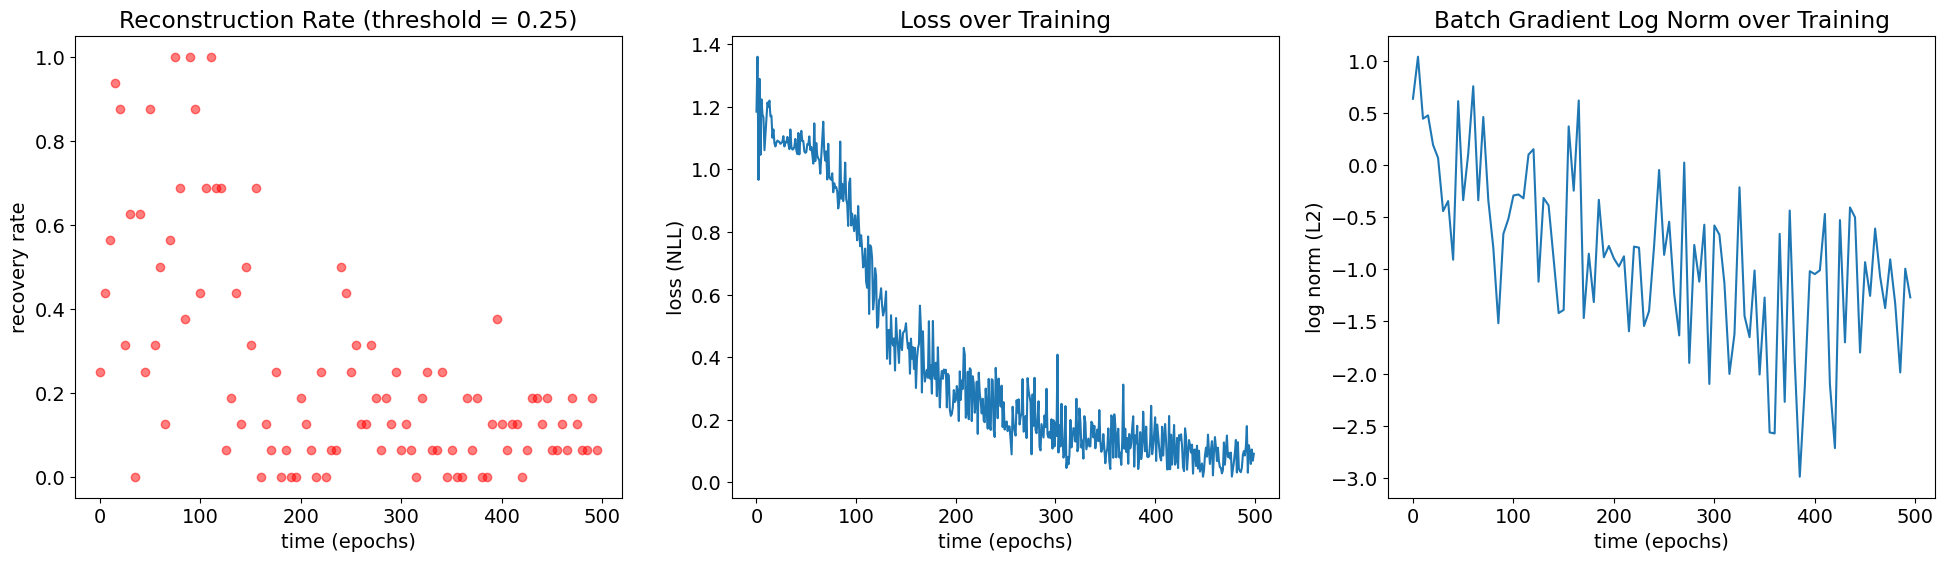

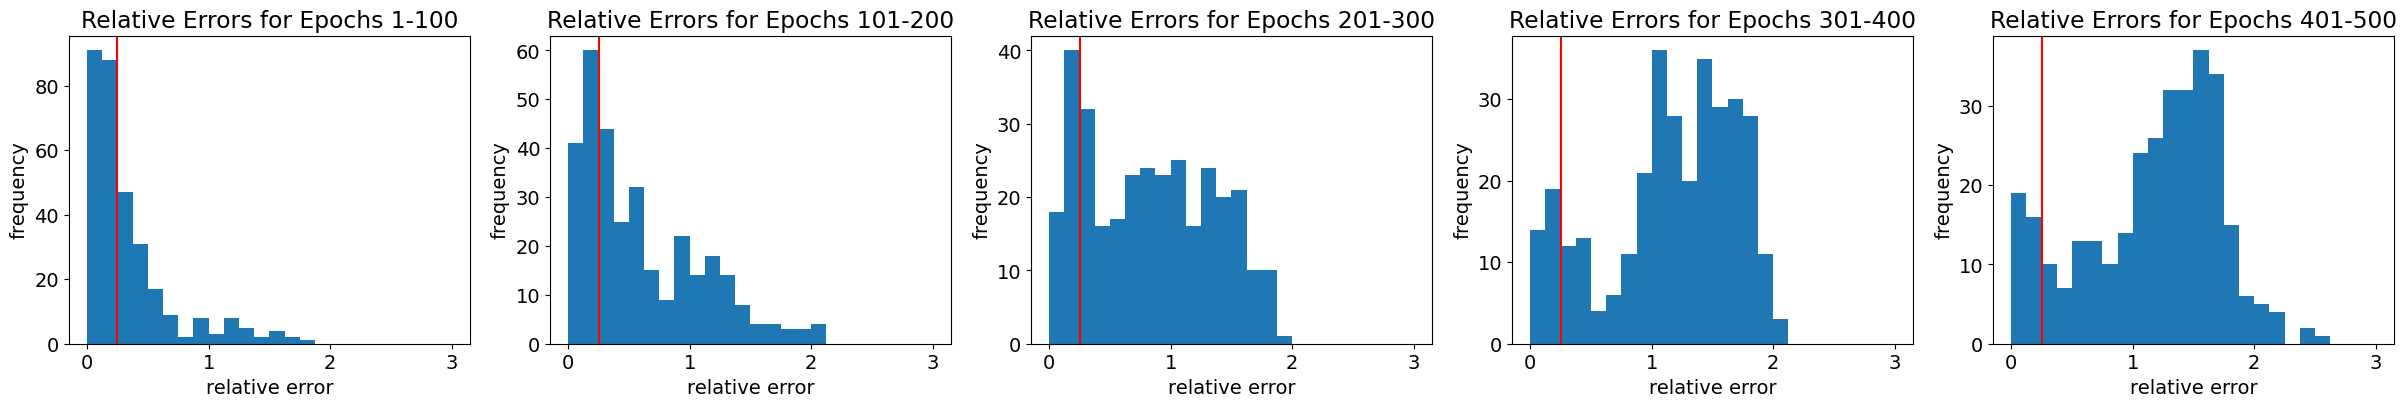

Note that in the histogram plots, a few outliers with much greater relative errors were ignored in favor of the majority of the data points
This is for the complete assignment
the red line indicates the reconstruction rate threshold


In [28]:
#@title summary plots for complete assignment (reconstruction rate, loss, batch gradient norm, relative errors)
rows = 1; cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))

# make text visible
plt.rcParams.update({'font.size': 14})

# dlg summary
axs[0].plot(dlg_timestamps, AA_RRate, 'ro', alpha=0.5)
axs[0].set(title='Reconstruction Rate (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1].plot(list(range(epochs)), losses)
axs[1].set(title='Loss over Training', xlabel='time (epochs)', ylabel='loss (NLL)')

axs[2].plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
axs[2].set(title='Batch Gradient Log Norm over Training', xlabel='time (epochs)', ylabel='log norm (L2)')

plt.savefig('train_DLG_16_big_summary.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# relative errors histogram plot
cnt = 20 # *** note that this must divide the number of dlg samples
dlg_rate = dlg_timestamps[1] - dlg_timestamps[0]
group_size = cnt*dlg_rate
batch_AA_REs = [torch.flatten(torch.tensor(AA_REs[i:i+cnt])).numpy() for i in range(0, len(AA_RRate), cnt)]
rows2 = 1; cols2 = 5
fig2, axs2 = plt.subplots(rows2, cols2, figsize=(6*cols2, 4*rows2))

for i in range(5):
    axs2[i].hist(batch_AA_REs[i], bins=24, range=[0, 3])
    axs2[i].set(title=f'Relative Errors for Epochs {group_size*i + 1}-{group_size*(i+1)}', xlabel='relative error', ylabel='frequency')
    axs2[i].axvline(0.25, color='red')

plt.savefig('train_DLG_16_big_AARE_hist.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

print('Note that in the histogram plots, a few outliers with much greater relative errors were ignored in favor of the majority of the data points')
print('This is for the complete assignment')
print('the red line indicates the reconstruction rate threshold')

Note that in the relative errors, a few outliers with much greater errors were ignored in favor of the majority of the data points


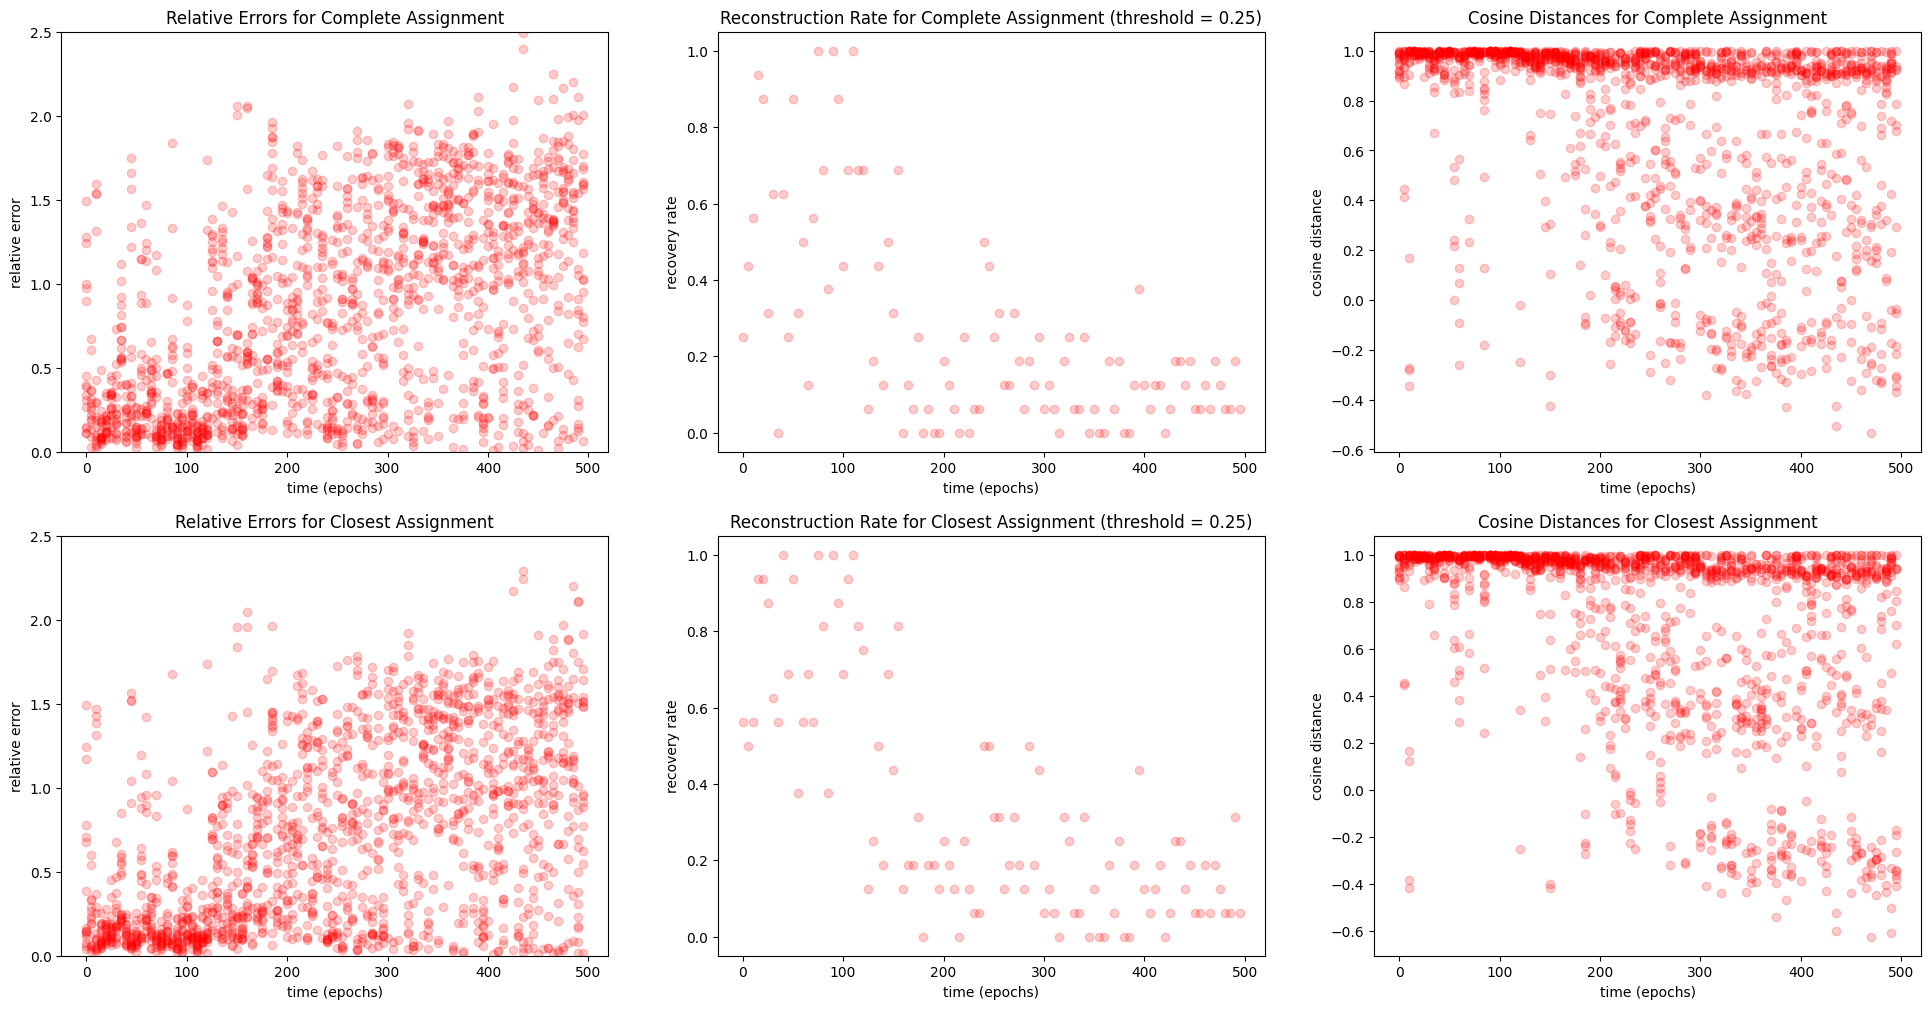

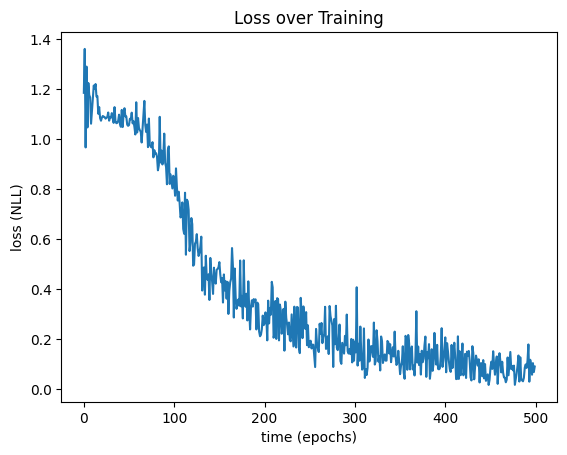

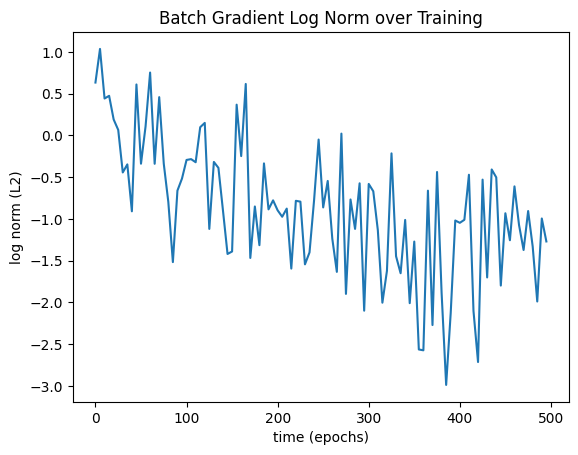

In [3]:
#@title create summary plots comparing both assignment methods (relative error, cosine distance, reconstruction rate, loss, batch gradient norm)
rows = 2; cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro', alpha=0.2)
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='relative error')
axs[0, 0].set_ylim([0, 2.5])

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro', alpha=0.2)
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro', alpha=0.2)
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='cosine distance')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro', alpha=0.2)
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='relative error')
axs[1, 0].set_ylim([0, 2.5])

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro', alpha=0.2)
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro', alpha=0.2)
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='cosine distance')

print('Note that in the relative errors, a few outliers with much greater errors were ignored in favor of the majority of the data points')

plt.savefig('train_DLG_16_big_errors.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('Loss over Training')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_DLG_16_big_loss.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('Batch Gradient Log Norm over Training')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

In [ ]:
#@title histogram plots for relative error and reconstruction rate
# plot a histogram of the DLG REs over time

# print(dlg_timestamps)
# print(AA_REs)
# print(AA_RRate)
# dlg_rate = dlg_timestamps[1] - dlg_timestamps[0]
# cnt = 10 # *** note that this must divide the number of dlg samples
# batch_timestamps = [min(i+cnt, len(dlg_timestamps))*dlg_rate for i in range(0, len(dlg_timestamps), cnt)]
# batch_AA_RRate = [AA_RRate[i:i+cnt] for i in range(0, len(AA_RRate), cnt)]
# print(batch_timestamps)
# print(batch_AA_RRate)

# plt.plot(batch_timestamps, batch_AA_RRate, 'ro', alpha=0.2)
# plt.title('Reconstruction Rate for Complete Assignment (threshold = 0.25)')
# plt.xlabel('time (epochs)') # batches the first t epochs into one column histogram
# plt.ylabel('recovery rate')

# print(dlg_timestamps)
# print(AA_REs)
dlg_rate = dlg_timestamps[1] - dlg_timestamps[0]
cnt = 20 # *** note that this must divide the number of dlg samples
batch_timestamps = [min(i+cnt, len(dlg_timestamps))*dlg_rate for i in range(0, len(dlg_timestamps), cnt)]
batch_AA_REs = [torch.flatten(torch.tensor(AA_REs[i:i+cnt])).numpy() for i in range(0, len(AA_RRate), cnt)]
# print(batch_timestamps)
# print(batch_AA_REs)

# for i in range(5):
#     plt.hist(batch_AA_REs[i], bins=20, range=[0, 3])
#     plt.title()
#     plt.xlabel('relative error') # batches the first t epochs into one column histogram
#     plt.ylabel('frequency')
#     plt.show()

rows2 = 1; cols2 = 5
fig2, axs2 = plt.subplots(rows2, cols2, figsize=(8*cols2, 6*rows2))

for i in range(5):
    axs2[i].hist(batch_AA_REs[i], bins=24, range=[0, 3])
    axs2[i].set(title=f'Relative Errors for Complete Assignment Epochs {100*i + 1}-{100*(i+1)}', xlabel='relative error', ylabel='frequency')
    axs2[i].axvline(0.25, color='red')

plt.show()
plt.savefig('train_DLG_16_big_AARE_hist.png', dpi=300)
print('Note that in the histogram plots, a few outliers with much greater relative errors were ignored in favor of the majority of the data points')
print('This is for the complete assignment')
print('the red line indicates the reconstruction rate threshold')

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo

# future tasks -----------------------------------------------------------
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)